In [ ]:
### local conda kernel - ds-gis

import itertools as itools

import pandas as pd
import numpy as np
import pathlib

import geopandas as gpd
import geopandas as pdg
import shapely
import reverse_geocoder


import copy

import math, os


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns


import glob



pd.set_option('display.max_columns', None)

%config Completer.use_jedi = False

DIR_dataset = r'E:\Projects\job_projects\ClimateTrace_TableauDashboard'
DIR_dataset = r'ClimateTrace_TableauDashboard'


In [4]:
DIR_dataset = r'ClimateTrace_TableauDashboard'

DIR_dataset = r'E:\Projects\job_projects\climateTrace\dataset_usa\climateTrace_emission_dataset'

dir_ls = glob.glob(  os.path.join( DIR_dataset, '**/' ), recursive= True  )[1:]  ## [1:]  to avoid the very root dir

In [5]:
emission_dictn = dict()

for edir in dir_ls:

    ## inside each sector dir
    file_ls = [  str(efile) for efile in pathlib.Path(edir).rglob( '*.csv' ) ]
    emissionFile_ls = [  efile for efile in file_ls if efile.endswith('_emissions-sources.csv')  ]
    
    sectornm = os.path.basename( os.path.normpath(edir) )
    sectornm = sectornm + '_df'  ## example: agric_df, fores_df

    concat_df = pd.DataFrame()

    for eEmission in emissionFile_ls:
        _dfi = pd.read_csv( eEmission )
        subSector = os.path.basename(eEmission).replace( '_emissions-sources.csv', '' )   ## clean subsector, ex. manure-management-cattle-feedlot
        _dfi['emission_subsector'] = subSector  ## a col value with subsector for later identification about the subsection source file
        concat_df = pd.concat(  [ concat_df, _dfi ], ignore_index= True )
    
    emission_dictn[sectornm] = concat_df  ## --> put all the section dfs into dict

C:\Users\madhur\AppData\Local\Temp\ipykernel_33848\401601090.py:15: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  _dfi = pd.read_csv( eEmission )


In [6]:
emission_dictn['transportation_df'].head(4)

,source_id,iso3_country,original_inventory_sector,start_time,end_time,temporal_granularity,gas,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_units,capacity_factor,activity,activity_units,created_date,modified_date,source_name,source_type,lat,lon,other1,other2,other3,other1_def,other2_def,other3_def,geometry_ref,emission_subsector
0,3170342,USA,domestic-aviation,2015-01-01 00:00:00,2015-12-31 00:00:00,annual,co2e_100yr,50264.000338,0.000089,NaN,11117.0,flights,NaN,15782.229604,T of fuel,2023-09-15 00:00:00,NaN,Lehigh Valley International Airport,domestic,40.651773,-75.442797,NaN,NaN,NaN,departure_airport_code,arrival_airport_name,arrival_airport_code,trace_-75.442797_40.651773,domestic-aviation
1,3170342,USA,domestic-aviation,2022-01-01 00:00:00,2022-12-31 00:00:00,annual,n2o,1.746198,0.000089,T of N2O per T of fuel burned,10960.0,flights,NaN,19708.780301,T of fuel,2024-02-27 00:00:00,2024-02-27 18:49:32.13701,Lehigh Valley International Airport,domestic,40.651773,-75.442797,NaN,NaN,NaN,departure_airport_code,arrival_airport_name,arrival_airport_code,trace_-75.442797_40.651773,domestic-aviation
2,3170342,USA,domestic-aviation,2016-01-01 00:00:00,2016-12-31 00:00:00,annual,ch4,0.340141,0.000022,T of CH4 per T of fuel burned,10309.0,flights,NaN,15356.231958,T of fuel,2023-09-15 00:00:00,2024-02-27 18:49:32.13701,Lehigh Valley International Airport,domestic,40.651773,-75.442797,NaN,NaN,NaN,departure_airport_code,arrival_airport_name,arrival_airport_code,trace_-75.442797_40.651773,domestic-aviation
3,3170342,USA,domestic-aviation,2016-01-01 00:00:00,2016-12-31 00:00:00,annual,co2e_20yr,48925.188048,0.000089,NaN,10309.0,flights,NaN,15356.231958,T of fuel,2023-09-15 00:00:00,2024-02-27 18:49:32.13701,Lehigh Valley International Airport,domestic,40.651773,-75.442797,NaN,NaN,NaN,departure_airport_code,arrival_airport_name,arrival_airport_code,trace_-75.442797_40.651773,domestic-aviation


In [7]:
_emission_dictn = copy.deepcopy(emission_dictn)

## columns to keep in the final dataframe; based on the observation
col2keep = [
    'source_id', 
    'gas',
    'source_type',
    'Emission_Sector',
    'emission_subsector',
    'start_time', 'end_time',
    'emissions_quantity', 'emissions_factor', 'emissions_factor_units',
    'capacity', 'capacity_factor', 'capacity_units',
    'activity', 'activity_units',
    'lat', 'lon', 'geometry_ref',
]

### create a single dataframe with all the sectors
df_ls = []
for k, v_df in _emission_dictn.items():
    v_df['Emission_Sector'] = k.replace('_df', '').capitalize()  ## add a col with sector name
    v_df = v_df[ col2keep ]  ## keep only the required cols
    df_ls.append( v_df )

_emission_df = pd.concat( df_ls, ignore_index= True, axis= 'rows')

print(  _emission_df.shape  ); _emission_df.head(2)

(3673385, 18)


,source_id,gas,source_type,Emission_Sector,emission_subsector,start_time,end_time,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_factor,capacity_units,activity,activity_units,lat,lon,geometry_ref
0,10758245,co2,NaN,Agriculture,cropland-fires,2022-01-01 00:00:00,2022-12-31 00:00:00,371054.286765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.03427,-109.645412,gadm_USA.27_1
1,11298285,co2,NaN,Agriculture,cropland-fires,2022-01-01 00:00:00,2022-12-31 00:00:00,4576.330887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,gadm_USA.1.45_1


In [8]:
## replace: 'co2', 'co2e_100yr', 'co2e_20yr'  to 'co2' for easiness
_emission_dfg = ( copy.deepcopy( _emission_df)
    ### .assign(  gas= lambda df: df['gas'].replace( {'co2e_100yr': 'co2', 'co2e_20yr': 'co2'}, regex= True ) ) 
    .pipe(  lambda df: df[ ~df['gas'].isin( ['co2e_100yr', 'co2e_20yr'] ) ]  )  ## drop rows with 'co2e_100yr' or 'co2e_20yr'
    .assign(  
        #### convert  start_time to datetime - split the start_time into date and time and only keep the date part
            _start_time = lambda df: df['start_time'].apply( lambda _df: _df.split( ' ' )[0].strip() ), 
            start_date = lambda df: pd.to_datetime( df['_start_time'], errors= 'coerce' ),

            _end_time= lambda df: df['end_time'].apply( lambda _df: _df.split( ' ' )[0].strip() ),
            end_date = lambda df: pd.to_datetime( df['_end_time'], errors= 'coerce' ),
            
            observed_months= lambda df: (df['end_date'] - df['start_date']).dt.days // 30,  ## calculate no of months between _start_time and _end_time

    )
    ## drop rows where Emission_Sector is Manufacturing or Transportation ( because their start and end date is not a year apart and thus making it simple)
    .pipe(  lambda df: df[ ~df['Emission_Sector'].isin( ['Manufacturing', 'Transportation'] ) ]  ) 
    .reset_index( drop= True ) 

    #### extract year as np.int16 from start_date and end_date
    .assign( year = lambda df: df['start_date'].dt.year.astype( np.int16 ) )
    .drop(  columns= [ 'start_date', 'end_date', '_start_time', '_end_time', 'start_time', 'end_time' ], axis= 1 )  ## drop the intermediate cols

    ## drop the year 2014 as it is not complete dataset and will not provide correct result when aggregating
    .pipe(  lambda df: df[ df['year'] != 2014 ]  ) 
    .reset_index( drop= True )

    ### get a geom from lat and lon
    .assign(    geometry= lambda df: gpd.points_from_xy(  df['lon'], df['lat'], crs= 'EPSG:4269'   )    )
    ## convert to GeoDataFrame with EPSG:4269 CRS
    .pipe(  pdg.GeoDataFrame, geometry= 'geometry', crs= 'EPSG:4269' )   

)

print( _emission_dfg.shape ); print( type(_emission_dfg) ); _emission_dfg.head(4)

(1500396, 19)
<class 'geopandas.geodataframe.GeoDataFrame'>


,source_id,gas,source_type,Emission_Sector,emission_subsector,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_factor,capacity_units,activity,activity_units,lat,lon,geometry_ref,observed_months,year,geometry
0,10758245,co2,NaN,Agriculture,cropland-fires,371054.286765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.03427,-109.645412,gadm_USA.27_1,12.0,2022,POINT (-109.64541 47.03427)
1,11298285,co2,NaN,Agriculture,cropland-fires,4576.330887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,gadm_USA.1.45_1,12.0,2022,POINT (-86.55053 34.76352)
2,11298285,ch4,NaN,Agriculture,cropland-fires,8.155843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,gadm_USA.1.45_1,12.0,2022,POINT (-86.55053 34.76352)
3,11298285,n2o,NaN,Agriculture,cropland-fires,0.211448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,gadm_USA.1.45_1,12.0,2022,POINT (-86.55053 34.76352)


In [9]:
DIR_shpfile = r'E:\Projects\job_projects\climateTrace\dataset_usa'
us_shp = os.path.join( DIR_shpfile, 'cb_2016_us_state_5m/cb_2016_us_state_5m.shp' )

STATE_SANS_LS = [  'Alaska', 'American Samoa', 'Guam', 'Hawaii', 'Puerto Rico', 'United States Virgin Islands', 'Commonwealth of the Northern Mariana Islands' ]
CLIP_BOX = shapely.geometry.box( -150, 25, -60, 50 )  ## xmin, ymin, xmax, ymax (longitude, latitude)
print( CLIP_BOX )


POLYGON ((-60 25, -60 50, -150 50, -150 25, -60 25))


In [10]:
us_pop_df = (  pd.read_excel( r'E:\Projects\job_projects\climateTrace\dataset_usa\usa_area_pop.xlsx' )
    .assign(
        state = lambda df: df['state'].str.strip().str.capitalize(), 
        state_code = lambda df: df['state_code'].str.strip().str.upper()
    )
)

## read the US states shapefile and filter out the states that are not in the mainland USA
us_gdf = (   pdg.read_file( us_shp )
    ## filter out the states that are not in the mainland USA
    [  lambda df:  ~df['NAME'].isin( STATE_SANS_LS )  ]
    .assign(
        geometry = lambda df: df['geometry'].intersection( CLIP_BOX ),
        state = lambda df: df['NAME'].str.strip().str.capitalize(), 
        state_code = lambda df: df['STUSPS'].str.strip().str.upper()
    )
    .filter( [ 'state', 'state_code', 'geometry' ], axis= 1 )

    ## merge with us_pop_df to get the population and area data
    .merge( us_pop_df.drop( columns= ['state'] ), how= 'left', on= 'state_code' )
)
us_gdf.head()

,state,state_code,geometry,pop2020,area_sq_mile,popDensity_popSqMile
0,Alabama,AL,"MULTIPOLYGON (((-88.03661 30.52049, -88.02473 ...",5024279,49804.218052,100.880592
1,Arizona,AZ,"POLYGON ((-114.80939 32.61712, -114.79756 32.6...",7151502,111667.628698,64.042750
2,Colorado,CO,"POLYGON ((-109.05954 38.71989, -109.05739 38.7...",5773714,108260.109182,53.331869
3,Connecticut,CT,"POLYGON ((-73.69595 41.11543, -73.63967 41.141...",3605944,5393.748666,668.541347
4,Florida,FL,"MULTIPOLYGON (((-82.25578 26.70344, -82.25516 ...",21538187,53683.387515,401.207673


In [11]:
## Spatial Join to get state name and other info 

emission_dfg = _emission_dfg.sjoin( us_gdf, how= 'inner', predicate= 'within'  )\
    .drop( columns= ['index_right'], errors= 'ignore' )
emission_dfg.head(3)

## rmoeve geo component from the emission_dfg
emission_df = ( copy.deepcopy( emission_dfg )
    .drop( columns= [ 'geometry', 'geometry_ref', 'observed_months' ], axis= 1, errors= 'ignore' ) 
    .assign(    source_type = lambda df: df['source_type'].fillna('other')   )

)
print( emission_df.shape ); emission_df.head(3)

(1484637, 21)


,source_id,gas,source_type,Emission_Sector,emission_subsector,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_factor,capacity_units,activity,activity_units,lat,lon,year,state,state_code,pop2020,area_sq_mile,popDensity_popSqMile
0,10758245,co2,other,Agriculture,cropland-fires,371054.286765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.03427,-109.645412,2022,Montana,MT,1084225,174044.542137,6.229583
1,11298285,co2,other,Agriculture,cropland-fires,4576.330887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,2022,Alabama,AL,5024279,49804.218052,100.880592
2,11298285,ch4,other,Agriculture,cropland-fires,8.155843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,2022,Alabama,AL,5024279,49804.218052,100.880592


In [12]:
EMMISSION_SECTOR_dictn = {
    # 'Agriculture', 'Power', 'Waste',
    'Forestry_and_land_use': 'Forest & LandUse',
    'Fossil_fuel_operations': 'Fossil Fuel Operation',
    'Mineral_extraction': 'Mineral Extraction'

 }  

EMMISSION_SUB_SECTOR_Granular_dictn = {
    'coal-mining' : 'Mining - Coal', 'copper-mining': 'Mining - Copper', 'iron-mining': 'Mining - Iron',

    'cropland-fires': 'Fire - Cropland', 'wetland-fires': 'Fire - Wetland',
    'forest-land-fires': 'Fire - Forest', 'shrubgrass-fires': 'Fire - Shrubgrass',
    
    'enteric-fermentation-cattle-feedlot' : 'Enteric Fermentation by Cattle', 'enteric-fermentation-cattle-pasture': 'Enteric Fermentation by Cattle',
    'manure-left-on-pasture-cattle' : 'Manure Remains on Pasture Cattle', 'manure-management-cattle-feedlot': 'Manure Management - Cattle Feedlot',

    'forest-land-clearing': 'Forest Land Clearing', 'forest-land-degradation': 'Forest Land Degradation',
    
    'electricity-generation' : 'Electricity Generation',
    'water-reservoirs': 'Water Reservoirs',


    'net-forest-land': 'Forest', 'net-shrubgrass': 'Shrubgrass', 'net-wetland': 'Wetland',

    'oil-and-gas-refining' : 'Oil/Gas Refining',

    'rice-cultivation' : 'Rice Cultivation', 'synthetic-fertilizer-application': 'Synthetic Fertilizer Application',
    
    'solid-waste-disposal': 'Solid Waste Disposal', 'wastewater-treatment-and-discharge': 'Wastewater Treatment/Discharge',
    'removals': 'Removals',
}


EMMISSION_SUB_SECTOR_BROAD_dictn = {
    'coal-mining' : 'Mining', 'copper-mining': 'Mining', 'iron-mining': 'Mining',

    'cropland-fires': 'Fire', 'wetland-fires': 'Fire', 'forest-land-fires': 'Fire', 'shrubgrass-fires': 'Fire',
    
    'electricity-generation' : 'Electricity Generation',
    'water-reservoirs': 'Water Reservoirs',

    'enteric-fermentation-cattle-feedlot' : 'Enteric Fermentation by Cattle', 'enteric-fermentation-cattle-pasture': 'Enteric Fermentation by Cattle',
    'manure-left-on-pasture-cattle' : 'Manure - Cattle', 'manure-management-cattle-feedlot': 'Manure - Cattle',


    'net-forest-land': 'Forest', 'net-shrubgrass': 'Shrubgrass', 'net-wetland': 'Wetland',

    'oil-and-gas-refining' : 'Oil/Gas Refining',

    'rice-cultivation' : 'Rice Cultivation', 'synthetic-fertilizer-application': 'Synthetic Fertilizer Application',
    
    'solid-waste-disposal': 'Solid Waste Disposal', 'wastewater-treatment-and-discharge': 'Wastewater Treatment/Discharge',
    
    'forest-land-clearing': 'Forest Land Clearing', 'forest-land-degradation': 'Forest Land Degradation',
    'removals': 'Removals',
}


SOURCE_TYPE_Granular_dictn = {
    # 'Deep Conversion',
    # 'Hydroskimming',
    # 'Medium Conversion',
    # 'Refuse',
    # 'Sanitary Landfills',
    # 'Surface',
    # 'Underground',
    # 'Underground & Surface',

    'beef' : 'Beef', 'dairy': 'Dairy', 'fisheries' : 'Fisheries',

    'biomass' : 'Biomass', 'biomass, coal' : 'Biomass + Coal', 'biomass, coal, gas' : 'Biomass + Coal + Gas',
        'biomass, gas': 'Biomass + Gas', 'biomass, oil': 'Biomass + Oil', 'biomass, other_fossil' : 'Biomass + Fossil Fuel',

    'coal': 'Coal', 'coal, gas': 'Coal + Gas', 'coal, gas, oil' : 'Coal + Gas + Oil', 'coal, oil': 'Coal + Oil',
            'coal, gas, other_fossil' : 'Coal + Gas + Fossil Fuel',  'coal, other_fossil' : 'Coal + Fossil Fuel',

    'manure_management_beef' : 'Beef Manure Management', 'manure_management_dairy': 'Beef Manure Management',

    'copper-mine': 'Metal Mine', 'iron-mine': 'Metal Mine',

    'domestic centralized aerobic advanced' : 'Domestic Centralized Aerobic',
        'domestic centralized aerobic primary': 'Domestic Centralized Aerobic',
        'domestic centralized aerobic secondary': 'Domestic Centralized Aerobic',
        
    'navigation': 'Navigation', 'hydroelectricity': 'Hydroelectricity', 'recreation': 'Recreation',
    'irrigation' : 'Irrigation', 'flood control': 'Flood Control',

    'gas': 'Gas', 'gas, coal': 'Coal + Gas', 'gas, coal, oil': 'Coal + Gas + Oil',
        'gas, oil': 'Gas + Oil', 'gas, other_fossil': 'Gas + Fossil Fuel', 'gas, waste': 'Gas + Waste',

    'oil': 'Oil', 'oil, biomass': 'Biomass + Oil', 'oil, gas': 'Gas + Oil', 'other' : 'Other',
    'waste, oil': 'Oil + Waste',
    'other_fossil': 'Fossil Fuel', 'other_fossil, oil': 'Oil + Fossil Fuel',
    
    'waste': 'Waste',
    
    'water supply': 'Water Supply'
 }


SOURCE_TYPE_BROAD_dictn = {
    'Deep Conversion' : 'Medium/Deep Conversion',
    'Medium Conversion': 'Medium/Deep Conversion',
    # 'Hydroskimming',
    # 'Refuse',
    'Surface': 'Surface/Underground Operations',
    'Underground' : 'Surface/Underground Operations',
    'Underground & Surface' : 'Surface/Underground Operations',

    'beef' : 'Animal-based Products', 'dairy': 'Animal-based Products', 'fisheries' : 'Animal-based Products',

    'biomass' : 'Biomass', 'biomass, coal' : 'Biomass & Mixed Fossil', 'biomass, coal, gas' : 'Biomass & Mixed Fossil',
        'biomass, gas': 'Biomass & Mixed Fossil', 'biomass, oil': 'Biomass & Mixed Fossil', 'biomass, other_fossil' : 'Biomass & Mixed Fossil',
    'coal': 'Fossil Fuels', 'coal, gas': 'Fossil Fuels', 'coal, gas, oil' : 'Fossil Fuels', 'coal, oil': 'Fossil Fuels',
        'coal, gas, other_fossil' : 'Fossil Fuels',  'coal, other_fossil' : 'Fossil Fuels',
    'gas': 'Fossil Fuels', 'gas, coal': 'Fossil Fuels', 'gas, coal, oil': 'Fossil Fuels',
        'gas, oil': 'Fossil Fuels', 'gas, other_fossil': 'Fossil Fuels', 'gas, waste': 'Fossil Fuels',
    'oil': 'Fossil Fuels', 'oil, biomass': 'Fossil Fuels', 'oil, gas': 'Fossil Fuels',
    'waste, oil': 'Fossil Fuels', 'other_fossil': 'Fossil Fuel', 'other_fossil, oil': 'Fossil Fuels',

    'copper-mine': 'Metal Mine', 'iron-mine': 'Metal Mine',

    'domestic centralized aerobic advanced' : 'Domestic Centralized Aerobic',
        'domestic centralized aerobic primary': 'Domestic Centralized Aerobic',
        'domestic centralized aerobic secondary': 'Domestic Centralized Aerobic',
        
    'navigation': 'Water Infrastructure, Management & Human-Water Interaction',
    'hydroelectricity': 'Water Infrastructure, Management & Human-Water Interaction',
    'recreation': 'Water Infrastructure, Management & Human-Water Interaction',
    'irrigation' : 'Water Infrastructure, Management & Human-Water Interaction',
    'flood control': 'Water Infrastructure, Management & Human-Water Interaction',
    'water supply': 'Water Infrastructure, Management & Human-Water Interaction',

    'manure_management_beef' : 'Manure Management', 'manure_management_dairy': 'Manure Management',
    
    'other' : 'Other',
    
    'waste': 'Waste Management',  'Sanitary Landfills': 'Waste Management',
    
 }


COL_ORDER_ls = [
    'source_ID', 'Emission_Sector', 'EmissionSubsector_Broad', 'EmissionSubsector_Granular', 'SourceType_Broad', 'SourceType_Granular',
    'gas', 'year', 'emissions_quantity',
    'emissions_factor', 'emissions_factor_units', 'capacity', 'capacity_factor', 'capacity_units', 'activity', 'activity_units',
    'lat', 'lon', 'state', 'state_code', 'pop2020', 'area_sq_mile',  'popDensity_popSqMile'
]



In [13]:
emission_df['Emission_Sector'].unique()

array(['Agriculture', 'Forestry_and_land_use', 'Fossil_fuel_operations',
       'Mineral_extraction', 'Power', 'Waste'], dtype=object)

In [15]:
print( emission_df.shape ); emission_df.head(3)

(1484637, 21)


,source_id,gas,source_type,Emission_Sector,emission_subsector,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_factor,capacity_units,activity,activity_units,lat,lon,year,state,state_code,pop2020,area_sq_mile,popDensity_popSqMile
0,10758245,co2,other,Agriculture,cropland-fires,371054.286765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.03427,-109.645412,2022,Montana,MT,1084225,174044.542137,6.229583
1,11298285,co2,other,Agriculture,cropland-fires,4576.330887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,2022,Alabama,AL,5024279,49804.218052,100.880592
2,11298285,ch4,other,Agriculture,cropland-fires,8.155843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,2022,Alabama,AL,5024279,49804.218052,100.880592


In [16]:
#### additional manual cleaning based on the observation

emission_cleaned_df = (  copy .deepcopy( emission_df  ) 
    .assign(
        gas = lambda df: df['gas'].str.upper(),
        Emission_Sector = lambda df: df['Emission_Sector'].replace(  EMMISSION_SECTOR_dictn ),

        EmissionSubsector_Broad = lambda df: df['emission_subsector'].replace(  EMMISSION_SUB_SECTOR_BROAD_dictn ),
        EmissionSubsector_Granular = lambda df: df['emission_subsector'].replace(  EMMISSION_SUB_SECTOR_Granular_dictn ),
        
        SourceType_Broad = lambda df: df['source_type'].replace(  SOURCE_TYPE_BROAD_dictn ),
        SourceType_Granular = lambda df: df['source_type'].replace(  SOURCE_TYPE_Granular_dictn ),
            
    )  

    .drop(  columns= [ 'emission_subsector', 'source_type', 'source_id' ], axis= 1, errors= 'ignore'  )
    .reset_index( names= 'source_ID' )
    
    .pipe(    lambda df:  df[  [  *filter( df.columns.__contains__, COL_ORDER_ls ), *df.columns.difference(COL_ORDER_ls)  ]  ]    )

    ## get lat lon as tuples for reverse geocoding
    .assign(   lat_lon = lambda df: list( zip( df['lat'], df['lon'] ) )   )
                       
)

print( emission_cleaned_df.shape ); emission_cleaned_df.head(3)

(1484637, 24)


,source_ID,Emission_Sector,EmissionSubsector_Broad,EmissionSubsector_Granular,SourceType_Broad,SourceType_Granular,gas,year,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_factor,capacity_units,activity,activity_units,lat,lon,state,state_code,pop2020,area_sq_mile,popDensity_popSqMile,lat_lon
0,0,Agriculture,Fire,Fire - Cropland,Other,Other,CO2,2022,371054.286765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.03427,-109.645412,Montana,MT,1084225,174044.542137,6.229583,"(47.03427022036337, -109.64541228840676)"
1,1,Agriculture,Fire,Fire - Cropland,Other,Other,CO2,2022,4576.330887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,Alabama,AL,5024279,49804.218052,100.880592,"(34.76351985476095, -86.55053338069244)"
2,2,Agriculture,Fire,Fire - Cropland,Other,Other,CH4,2022,8.155843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,Alabama,AL,5024279,49804.218052,100.880592,"(34.76351985476095, -86.55053338069244)"


In [20]:
### combine lat lon which helps in reverse geocoding to get city
latLon_ls = emission_cleaned_df['lat_lon'].tolist()
## get location dictionary from reverse geocoding using latlon tuple
location_dictn = reverse_geocoder.search( latLon_ls )

Loading formatted geocoded file...


In [21]:
### get location dictionary from reverse geocoding

emission_cleaned_df = (  emission_cleaned_df
    .assign(
        loc_dictn = location_dictn,
        city = lambda df: df['loc_dictn'].apply( lambda _df: _df['name'] ),
    )
    .drop( columns= ['loc_dictn', 'lat_lon'], axis= 1, errors= 'ignore'  )  ## drop the intermediate cols
)

emission_cleaned_df

,source_ID,Emission_Sector,EmissionSubsector_Broad,EmissionSubsector_Granular,SourceType_Broad,SourceType_Granular,gas,year,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_factor,capacity_units,activity,activity_units,lat,lon,state,state_code,pop2020,area_sq_mile,popDensity_popSqMile,city
0,0,Agriculture,Fire,Fire - Cropland,Other,Other,CO2,2022,371054.286765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.03427,-109.645412,Montana,MT,1084225,174044.542137,6.229583,Lewistown
1,1,Agriculture,Fire,Fire - Cropland,Other,Other,CO2,2022,4576.330887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,Alabama,AL,5024279,49804.218052,100.880592,Huntsville
2,2,Agriculture,Fire,Fire - Cropland,Other,Other,CH4,2022,8.155843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,Alabama,AL,5024279,49804.218052,100.880592,Huntsville
3,3,Agriculture,Fire,Fire - Cropland,Other,Other,N2O,2022,0.211448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,Alabama,AL,5024279,49804.218052,100.880592,Huntsville
4,4,Agriculture,Fire,Fire - Cropland,Other,Other,CO2,2017,4721.204408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,Alabama,AL,5024279,49804.218052,100.880592,Huntsville
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484632,1500391,Waste,Wastewater Treatment/Discharge,Wastewater Treatment/Discharge,Domestic Centralized Aerobic,Domestic Centralized Aerobic,CH4,2019,0.508038,0.000936,T of CH4 per T of BOD,542.803955,1.0,population served,542.803955,T of BOD,42.24900,-110.190000,Wyoming,WY,576851,107999.894284,5.341218,Marbleton
1484633,1500392,Waste,Wastewater Treatment/Discharge,Wastewater Treatment/Discharge,Domestic Centralized Aerobic,Domestic Centralized Aerobic,N2O,2019,0.148746,0.000274,T of N2O per T of BOD,542.803955,1.0,population served,542.803955,T of BOD,42.24900,-110.190000,Wyoming,WY,576851,107999.894284,5.341218,Marbleton
1484634,1500393,Waste,Wastewater Treatment/Discharge,Wastewater Treatment/Discharge,Domestic Centralized Aerobic,Domestic Centralized Aerobic,CO2,2018,0.000000,0.000000,T of CO2 per T of BOD,540.337747,1.0,population served,540.337747,T of BOD,42.24900,-110.190000,Wyoming,WY,576851,107999.894284,5.341218,Marbleton
1484635,1500394,Waste,Wastewater Treatment/Discharge,Wastewater Treatment/Discharge,Domestic Centralized Aerobic,Domestic Centralized Aerobic,CH4,2018,0.505730,0.000936,T of CH4 per T of BOD,540.337747,1.0,population served,540.337747,T of BOD,42.24900,-110.190000,Wyoming,WY,576851,107999.894284,5.341218,Marbleton


In [ ]:
emission_2020_df = emission_cleaned_df[ emission_cleaned_df[  'year'] == 2020 ].reset_index( drop= True )
emission_2020_sample_df = emission_2020_df[  emission_2020_df['Emission_Sector']\
    .isin( [ 'Mineral_extraction', 'Fossil_fuel_operations', 'Power' ] )  ].reset_index( drop= True )


In [ ]:
emission_cleaned_df = pd.read_csv(  r'ClimateTrace_TableauDashboard\dataset\emission_dataset.csv' )

C:\Users\madhur\AppData\Local\Temp\ipykernel_15720\2097180871.py:1: DtypeWarning: Columns (10,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  emission_cleaned_df = pd.read_csv(  r'E:\Projects\job_projects\ClimateTrace_TableauDashboard\dataset\emission_dataset.csv' )


<br><hr>
### data viz
<hr>

In [71]:
df = copy.deepcopy( emission_cleaned_df )

years = range(2015, 2023) # Years from 2015 to 2022


# Filter for non-zero emissions for many plots to better visualize trends in actual emitting sources
df_nonzero_emissions = df[df['emissions_quantity'] > 0].copy()
df_nonzero_emissions = df[df['emissions_quantity'] > 0].copy()

print(df.info())
print( df.shape ); df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484637 entries, 0 to 1484636
Data columns (total 24 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   source_ID                   1484637 non-null  int64  
 1   Emission_Sector             1484637 non-null  object 
 2   EmissionSubsector_Broad     1484637 non-null  object 
 3   EmissionSubsector_Granular  1484637 non-null  object 
 4   SourceType_Broad            1484637 non-null  object 
 5   SourceType_Granular         1484637 non-null  object 
 6   gas                         1484637 non-null  object 
 7   year                        1484637 non-null  int16  
 8   emissions_quantity          918295 non-null   float64
 9   emissions_factor            750734 non-null   float64
 10  emissions_factor_units      862641 non-null   object 
 11  capacity                    1127451 non-null  float64
 12  capacity_factor             1098822 non-null  float64
 1

,source_ID,Emission_Sector,EmissionSubsector_Broad,EmissionSubsector_Granular,SourceType_Broad,SourceType_Granular,gas,year,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_factor,capacity_units,activity,activity_units,lat,lon,state,state_code,pop2020,area_sq_mile,popDensity_popSqMile,city
0,0,Agriculture,Fire,Fire - Cropland,Other,Other,CO2,2022,371054.286765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.03427,-109.645412,Montana,MT,1084225,174044.542137,6.229583,Lewistown
1,1,Agriculture,Fire,Fire - Cropland,Other,Other,CO2,2022,4576.330887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,Alabama,AL,5024279,49804.218052,100.880592,Huntsville
2,2,Agriculture,Fire,Fire - Cropland,Other,Other,CH4,2022,8.155843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,Alabama,AL,5024279,49804.218052,100.880592,Huntsville
3,3,Agriculture,Fire,Fire - Cropland,Other,Other,N2O,2022,0.211448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,Alabama,AL,5024279,49804.218052,100.880592,Huntsville
4,4,Agriculture,Fire,Fire - Cropland,Other,Other,CO2,2017,4721.204408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.76352,-86.550533,Alabama,AL,5024279,49804.218052,100.880592,Huntsville


In [72]:
##3 plot setting

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.family'] = 'sans-serif' # Modern sans-serif font
plt.rcParams['figure.dpi'] = 100 # High resolution for better clarity
plt.rcParams['lines.linewidth'] = 2 # Thicker lines for trends
plt.rcParams['axes.grid'] = True # Ensure grid is visible
plt.style.use( style= 'dark_background' )


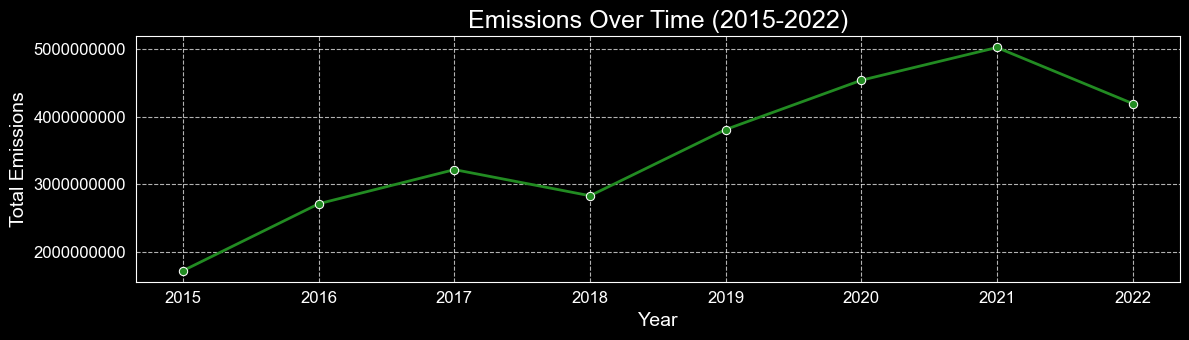

In [73]:
# --- 1. Overall Temporal Trends 
# 1.1 Total Emissions Over Time
plt.style.use( style= 'dark_background' )

plt.figure(figsize=(12, 3.5))
emissions_yearly = df_nonzero_emissions.groupby('year')['emissions_quantity'].sum()

sns.lineplot(x=emissions_yearly.index, y=emissions_yearly.values, marker='o', color='forestgreen')
plt.title('Emissions Over Time (2015-2022)', fontsize=18)
plt.xlabel('Year', fontsize=14); plt.ylabel('Total Emissions', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7); plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout(); plt.show()

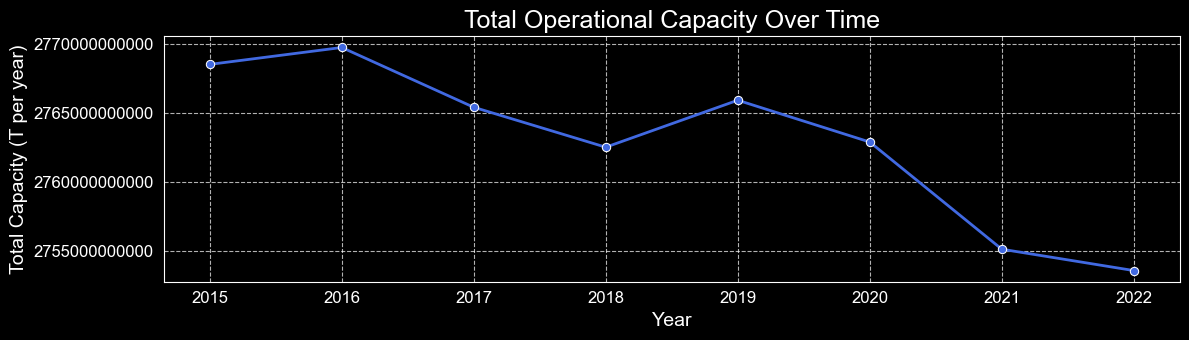

In [ ]:

# 1.3 Total Capacity Over Time

plt.figure(figsize=(12, 3.5))
total_capacity_yearly = df.groupby('year')['capacity'].sum()
sns.lineplot(x=total_capacity_yearly.index, y=total_capacity_yearly.values, marker='o', color='royalblue')
plt.title('Total Operational Capacity Over Time', fontsize=18)
plt.xlabel('Year', fontsize=14); plt.ylabel('Total Capacity (T per year)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7); plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout(); plt.show()

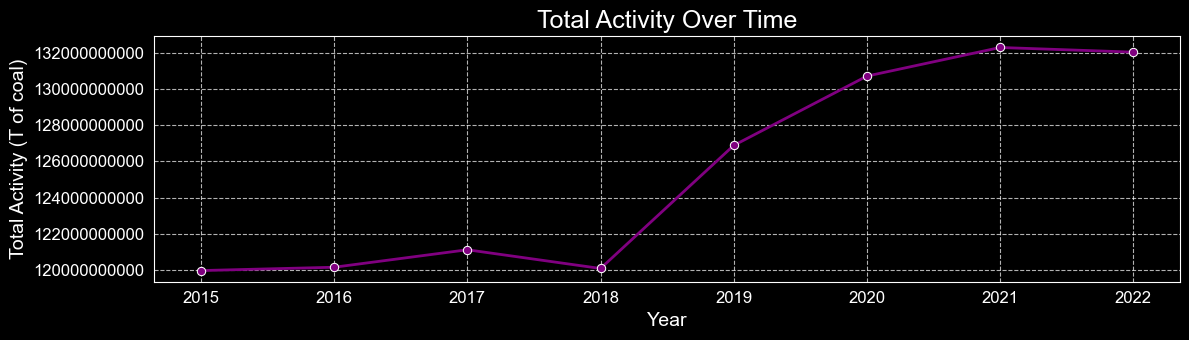

In [75]:
# 1.4 Total Activity Over Time

plt.figure(figsize=(12, 3.5))
total_activity_yearly = df.groupby('year')['activity'].sum()
sns.lineplot(x=total_activity_yearly.index, y=total_activity_yearly.values, marker='o', color='purple')
plt.title('Total Activity Over Time', fontsize=18)
plt.xlabel('Year', fontsize=14); plt.ylabel('Total Activity (T of coal)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7); plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout(); plt.show()

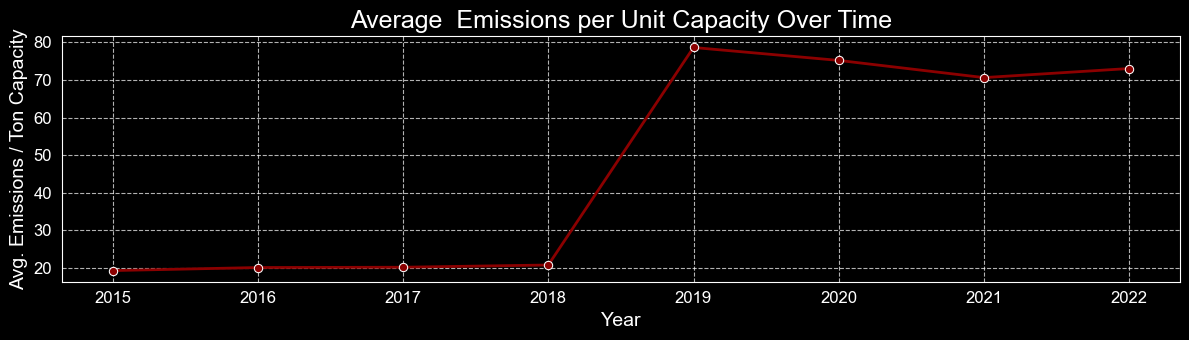

In [76]:
# 1.5 Emissions Intensity (per Capacity) Over Time

df_nonzero_emissions['emissions_per_capacity'] = df_nonzero_emissions['emissions_quantity'] / df_nonzero_emissions['capacity']
df_nonzero_emissions = df_nonzero_emissions[df_nonzero_emissions['emissions_per_capacity'].notna() & (df_nonzero_emissions['emissions_per_capacity'] != np.inf)].copy()

plt.figure(figsize=(12, 3.5))
avg_emissions_per_capacity_yearly = df_nonzero_emissions.groupby('year')['emissions_per_capacity'].mean()
sns.lineplot(x=avg_emissions_per_capacity_yearly.index, y=avg_emissions_per_capacity_yearly.values, marker='o', color='darkred')
plt.title('Average  Emissions per Unit Capacity Over Time', fontsize=18); plt.xlabel('Year', fontsize=14); plt.ylabel('Avg. Emissions / Ton Capacity', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()

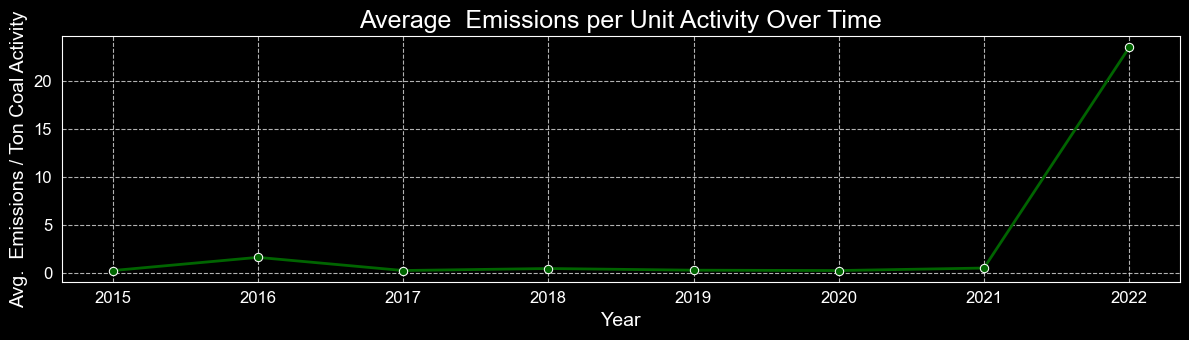

In [77]:
# 1.6  Emissions Intensity (per Activity) Over Time

df_nonzero_emissions['emissions_per_activity'] = df_nonzero_emissions['emissions_quantity'] / df_nonzero_emissions['activity']
df_nonzero_emissions = df_nonzero_emissions[df_nonzero_emissions['emissions_per_activity'].notna() & (df_nonzero_emissions['emissions_per_activity'] != np.inf)].copy()

plt.figure(figsize=(12, 3.5))
avg_emissions_per_activity_yearly = df_nonzero_emissions.groupby('year')['emissions_per_activity'].mean()
sns.lineplot(x=avg_emissions_per_activity_yearly.index, y=avg_emissions_per_activity_yearly.values, marker='o', color='darkgreen')
plt.title('Average  Emissions per Unit Activity Over Time', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Avg.  Emissions / Ton Coal Activity', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

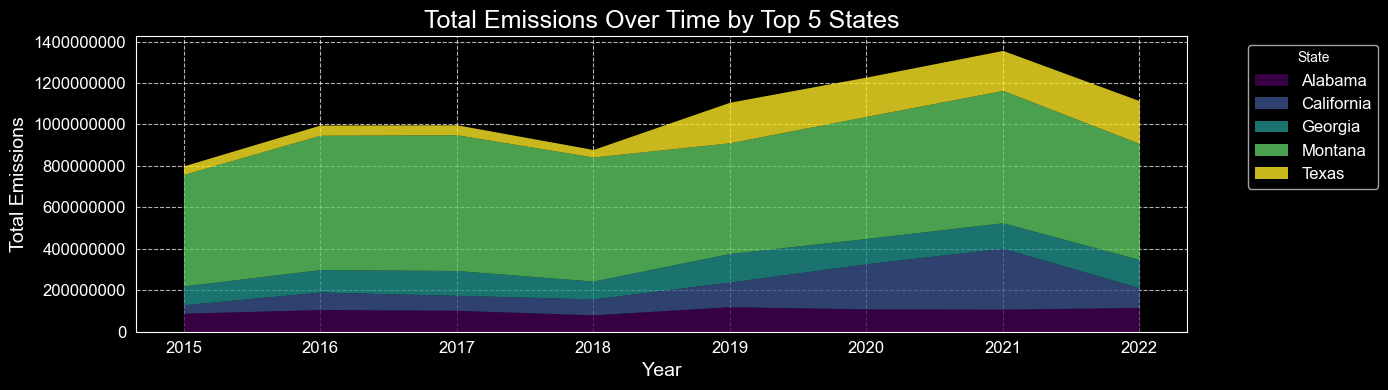

In [78]:
# 2.1 Top 5 States by Total Emissions Over Time (Stacked Area)
plt.figure(figsize=(14, 4))

top_5_states = df_nonzero_emissions.groupby('state')['emissions_quantity'].sum().nlargest(5).index
df_top_5_yearly = df_nonzero_emissions[df_nonzero_emissions['state'].isin(top_5_states)].groupby(['year', 'state'])['emissions_quantity'].sum().unstack(fill_value=0)
df_top_5_yearly.plot(kind='area', stacked=True, ax=plt.gca(), cmap='viridis', alpha=0.8, linewidth=0)

plt.title('Total Emissions Over Time by Top 5 States', fontsize=18)
plt.xlabel('Year', fontsize=14) ; plt.ylabel('Total Emissions', fontsize=14); plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left'); plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout(); plt.show()

C:\Users\madhur\AppData\Local\Temp\ipykernel_33848\2722789646.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_emissions_state_latest.index, y=avg_emissions_state_latest.values, palette='coolwarm', )


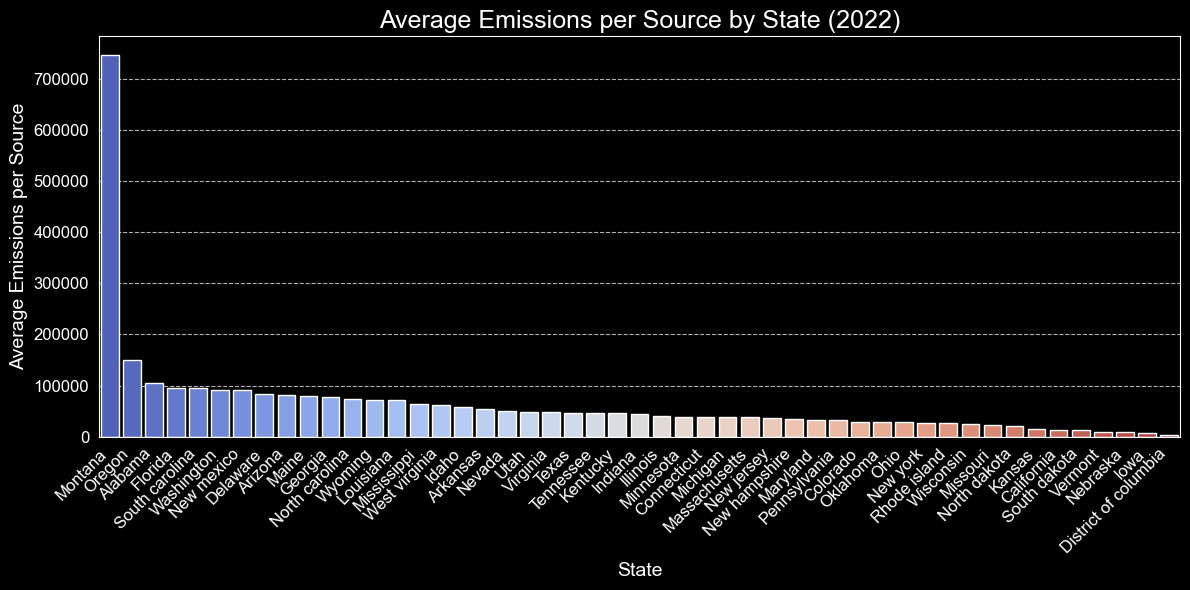

In [79]:
# 2.2 Average Emissions per Source by State (Latest Year Comparison - Bar Plot)
latest_year = df['year'].max()

latest_year = df['year'].max()
df_latest_year = df_nonzero_emissions[df_nonzero_emissions['year'] == latest_year].copy()
avg_emissions_state_latest = df_latest_year.groupby('state')['emissions_quantity'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_emissions_state_latest.index, y=avg_emissions_state_latest.values, palette='coolwarm', )
plt.title(f'Average Emissions per Source by State ({latest_year})', fontsize=18)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Emissions per Source', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

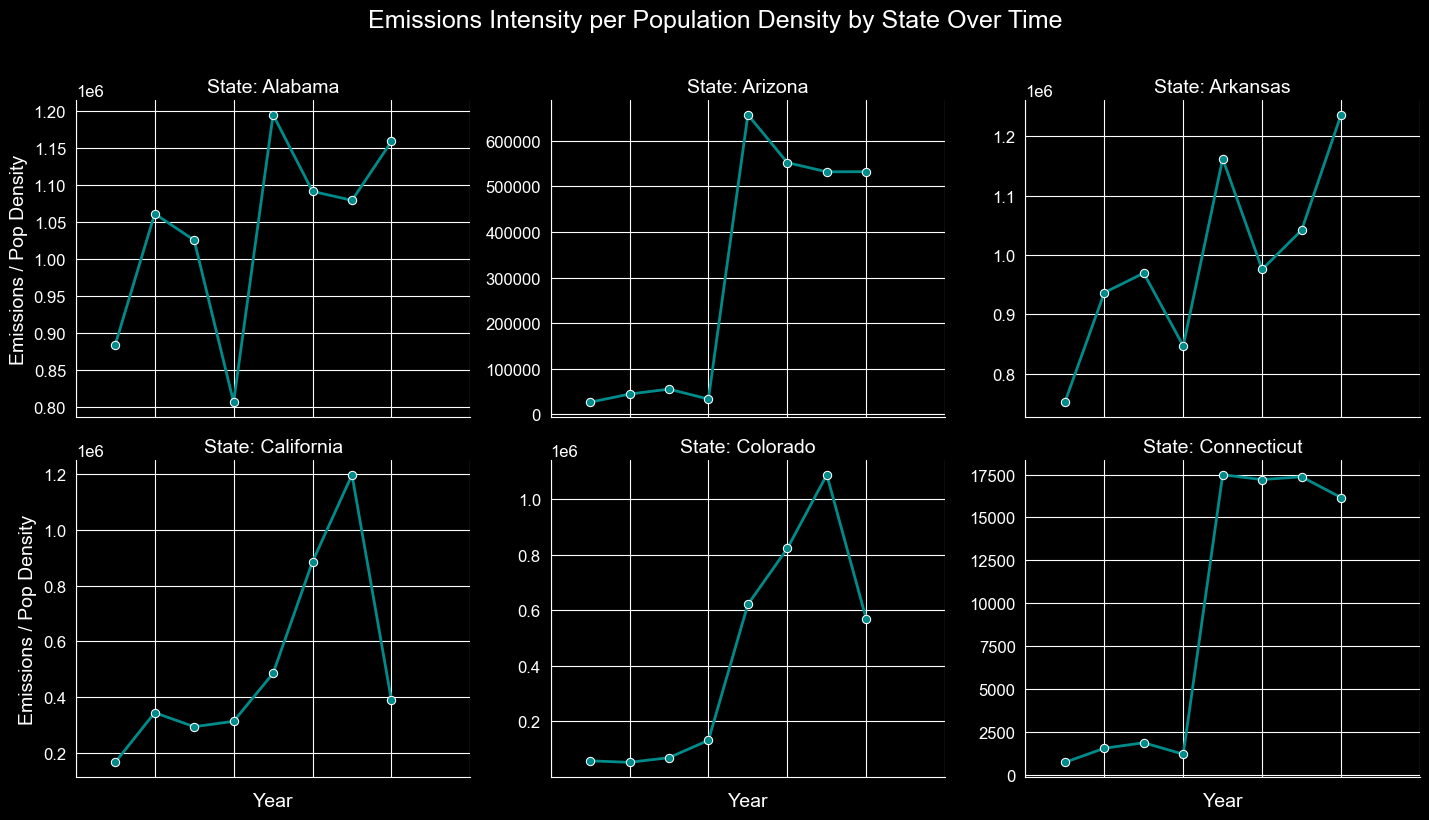

In [80]:
# 2.3 State-wise Emissions Intensity (per Population Density) Over Time
# Calculate total emissions and average pop density per state per year

df_state_yearly = (     df_nonzero_emissions.groupby(['year', 'state'])
    .agg(  total_emissions= ('emissions_quantity', 'sum'), avg_pop_density=('popDensity_popSqMile', 'mean')   )
    .reset_index()
    .pipe( lambda df: df[  df['state'].str.startswith(('A', 'C'))  ] )  ### for briefness only using 6 states for now
    .reset_index( drop= True )
    )


df_state_yearly['emission_per_pop_density'] = df_state_yearly['total_emissions'] / df_state_yearly['avg_pop_density']
df_state_yearly = df_state_yearly[df_state_yearly['emission_per_pop_density'].notna() & (df_state_yearly['emission_per_pop_density'] != np.inf)].copy()

g = sns.FacetGrid(df_state_yearly, col='state', col_wrap=3, height=4, aspect=1.2, sharey=False)
g.map_dataframe(sns.lineplot, x='year', y='emission_per_pop_density', marker='o', color='darkcyan')
g.set_axis_labels("Year", "Emissions / Pop Density")
g.set_titles("State: {col_name}")
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('Emissions Intensity per Population Density by State Over Time', y=1.02, fontsize=18)
plt.tight_layout()
plt.show()

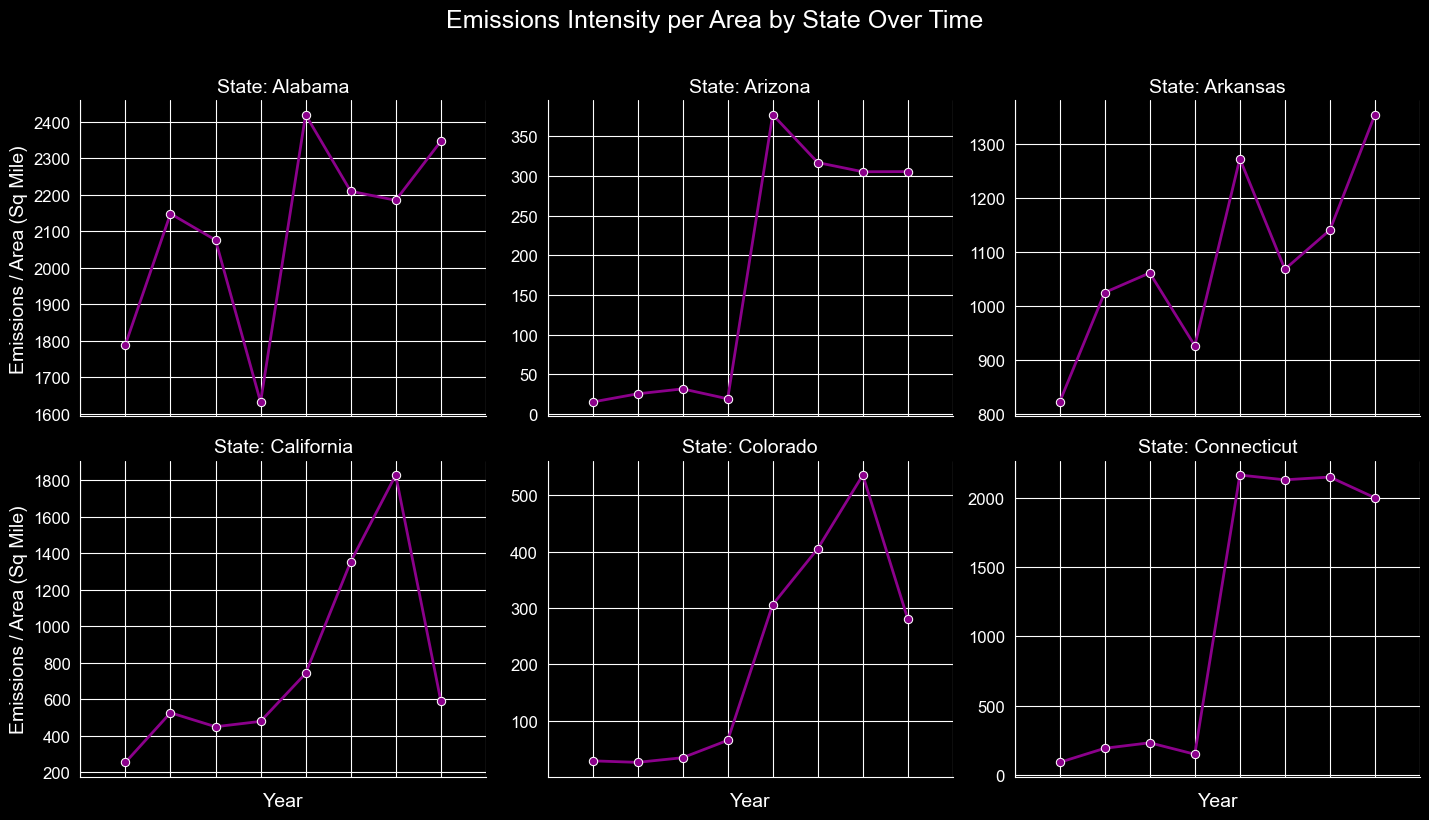

In [81]:
# 2.4 State-wise Emissions Intensity (per Area) Over Time

df_state_yearly_area = df_nonzero_emissions.groupby(['year', 'state']).agg(
    total_emissions=('emissions_quantity', 'sum'),
    avg_area=('area_sq_mile', 'mean')
).reset_index()\
    .pipe( lambda df: df[  df['state'].str.startswith(('A', 'C'))  ] )  ### for briefness only using 6 states for now

df_state_yearly_area['ch4_emissions_per_area'] = df_state_yearly_area['total_emissions'] / df_state_yearly_area['avg_area']
df_state_yearly_area = df_state_yearly_area[df_state_yearly_area['ch4_emissions_per_area'].notna() & (df_state_yearly_area['ch4_emissions_per_area'] != np.inf)].copy()

g = sns.FacetGrid(df_state_yearly_area, col='state', col_wrap=3, height=4, aspect=1.2, sharey=False)
g.map_dataframe(sns.lineplot, x='year', y='ch4_emissions_per_area', marker='o', color='darkmagenta')
g.set_axis_labels("Year", "Emissions / Area (Sq Mile)")
g.set_titles("State: {col_name}")
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('Emissions Intensity per Area by State Over Time', y=1.02, fontsize=18)
plt.tight_layout()
plt.show()

C:\Users\madhur\AppData\Local\Temp\ipykernel_33848\411754534.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='year', y='emissions_quantity', col='state', data=df_ch4_filtered_states_evolution,


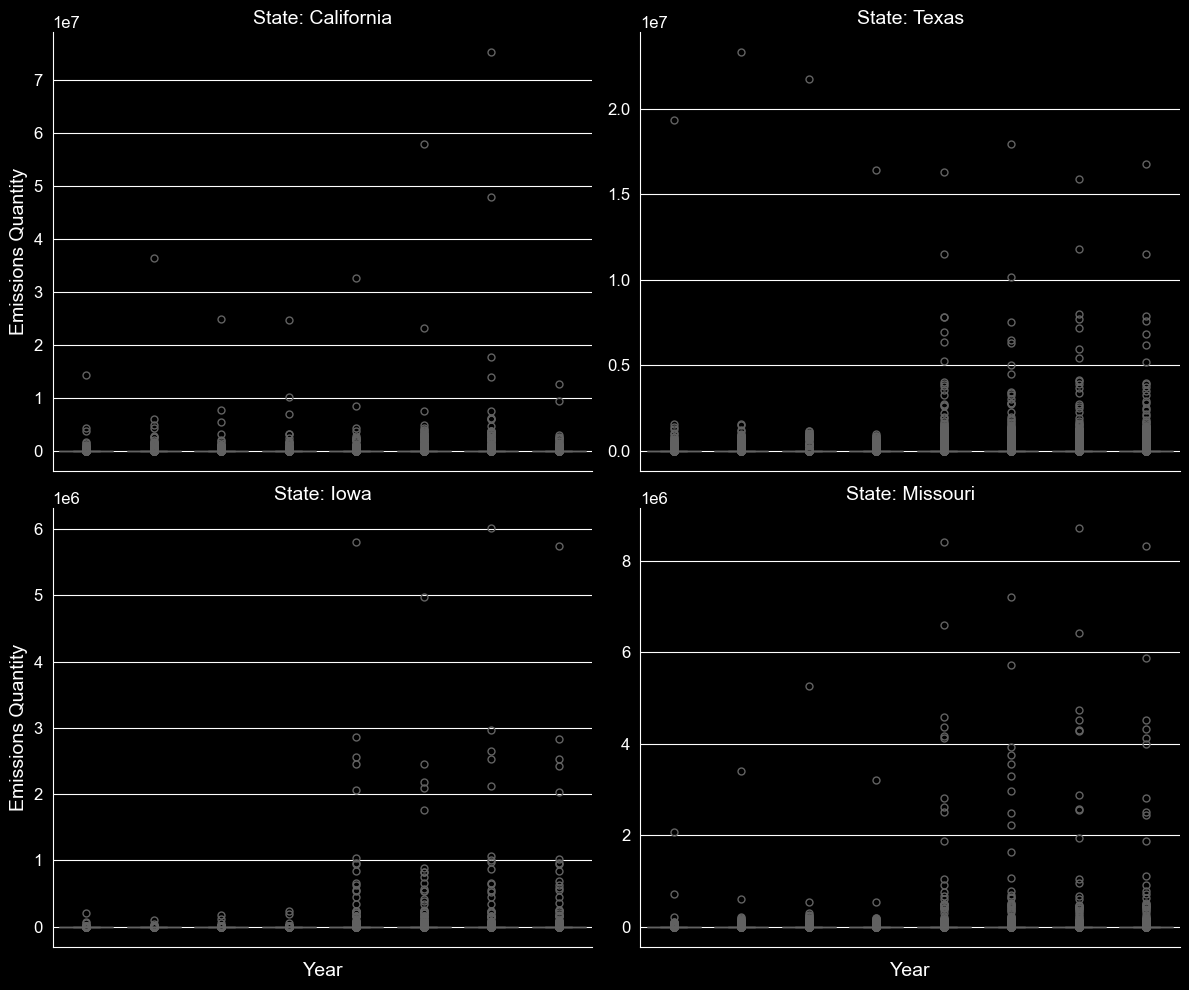

In [82]:
# 2.5 Distribution of Emissions by State (Box plots, showing evolution for top states)
top_states_for_box_evolution = df_nonzero_emissions['state'].value_counts().nlargest(4).index.tolist()
df_ch4_filtered_states_evolution = df_nonzero_emissions[df_nonzero_emissions['state'].isin(top_states_for_box_evolution)].copy()

g = sns.catplot(x='year', y='emissions_quantity', col='state', data=df_ch4_filtered_states_evolution,
                kind='box', col_wrap=2, height=5, aspect=1.2, palette='Set3', sharey=False)
g.set_axis_labels("Year", "Emissions Quantity")
g.set_titles("State: {col_name}")
g.set_xticklabels(rotation=45, ha='right')
plt.tight_layout()
plt.show()

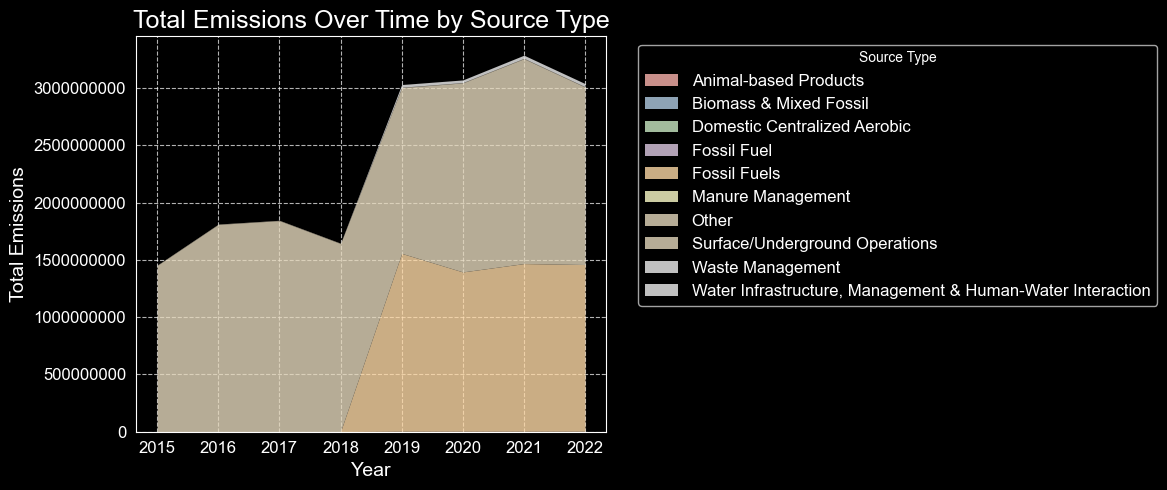

In [83]:
# --- 3. Source Type Analysis & Efficiency ---

# 3.1 Total Emissions by Source Type (Surface vs. Underground) Over Time
plt.figure(figsize=(12, 5))
total_ch4_emissions_by_type_yearly = df_nonzero_emissions.groupby(['year', 'SourceType_Broad'])['emissions_quantity'].sum().unstack(fill_value=0)
total_ch4_emissions_by_type_yearly.plot(kind='area', stacked=True, ax=plt.gca(), cmap='Pastel1', alpha=0.8, linewidth=0)
plt.title('Total Emissions Over Time by Source Type', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Emissions', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Source Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


In [ ]:
df_nonzero_emissions.head(3)

,source_ID,Emission_Sector,EmissionSubsector_Broad,EmissionSubsector_Granular,SourceType_Broad,SourceType_Granular,gas,year,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_factor,capacity_units,activity,activity_units,lat,lon,state,state_code,pop2020,area_sq_mile,popDensity_popSqMile,emissions_per_capacity,emissions_per_activity
75241,75937,Agriculture,Enteric Fermentation by Cattle,Enteric Fermentation by Cattle,Animal-based Products,Beef,CH4,2015,164.3,0.053,T of CH4 per animal head,1.0,3100.0,hectares,3100.0,animals,39.70237,-122.19670,California,CA,39538223,160878.883916,245.763907,164.3,0.05300
75245,75941,Agriculture,Enteric Fermentation by Cattle,Enteric Fermentation by Cattle,Animal-based Products,Beef,CH4,2021,103.9,0.053,T of CH4 per animal head,1.0,1960.0,hectares,1960.0,animals,36.06406,-119.36576,California,CA,39538223,160878.883916,245.763907,103.9,0.05301
75249,75945,Agriculture,Enteric Fermentation by Cattle,Enteric Fermentation by Cattle,Animal-based Products,Beef,CH4,2022,103.9,0.053,T of CH4 per animal head,1.0,1960.0,hectares,1960.0,animals,36.06406,-119.36576,California,CA,39538223,160878.883916,245.763907,103.9,0.05301


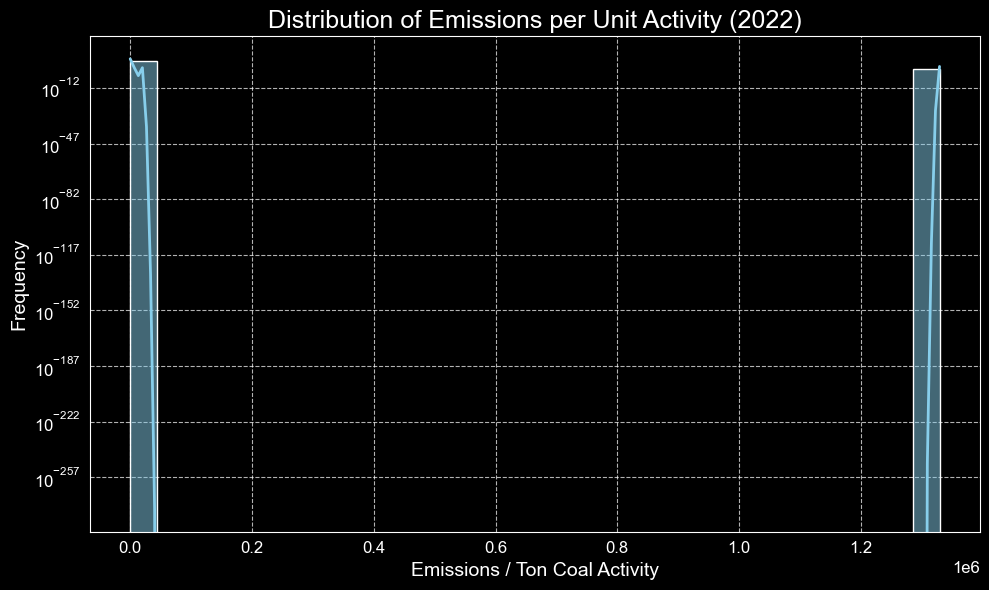

In [84]:
plt.style.use(style='dark_background')
# plt.style.use( style= 'classic' )

# 3.4 Distribution of Emissions per Unit Activity (Overall, for) - Latest Year
if not df_latest_year.empty:
    df_latest_year['emissions_per_activity'] = df_latest_year['emissions_quantity'] / df_latest_year['activity']
    df_latest_year_valid = df_latest_year[df_latest_year['emissions_per_activity'].notna() & (df_latest_year['emissions_per_activity'] != np.inf)].copy()

    if not df_latest_year_valid.empty:
        plt.figure(figsize=(10, 6))
        sns.histplot(df_latest_year_valid['emissions_per_activity'], kde=True, bins=30, color='skyblue')
        plt.title(f'Distribution of Emissions per Unit Activity ({latest_year})', fontsize=18)
        plt.xlabel('Emissions / Ton Coal Activity', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.yscale('log') # Log scale for emissions due to wide range
        plt.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()


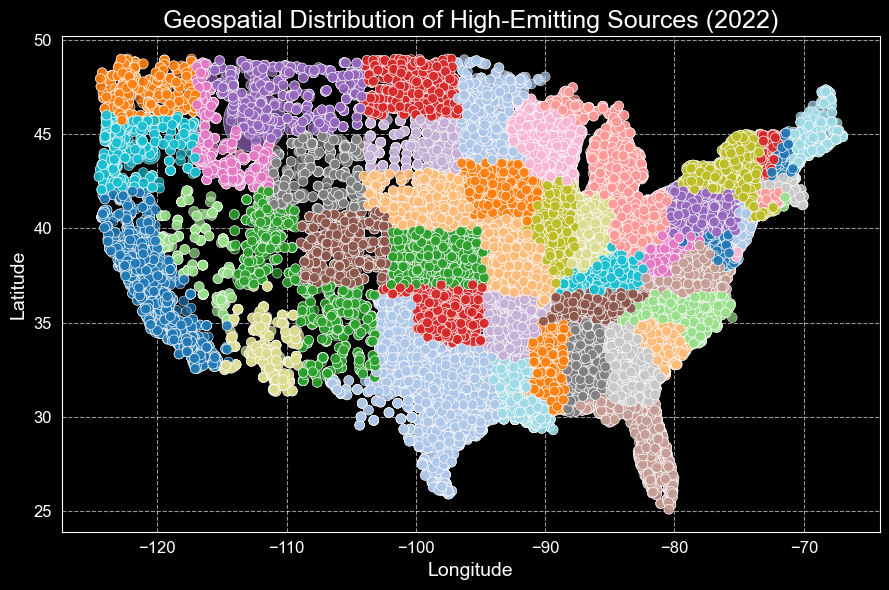

In [85]:

# --- 4. Geospatial & Contextual Insights ---

# 4.1 Geospatial Distribution of High-Emitting Sources (Bubble Map for the latest year)
# Using df_latest_year_nonzero_emissions to ensure only actual emitters are shown
df_latest_year_nonzero_emissions = df_nonzero_emissions[df_nonzero_emissions['year'] == latest_year].copy()

plt.figure(figsize=(9, 6))
sns.scatterplot(x='lon', y='lat', size='emissions_quantity', hue='state',
                sizes=(50, 2000), data=df_latest_year_nonzero_emissions,
                palette='tab20', alpha=0.7, edgecolor='w', linewidth=0.5, legend= False)
plt.title(f'Geospatial Distribution of High-Emitting Sources ({latest_year})', fontsize=18)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
# plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


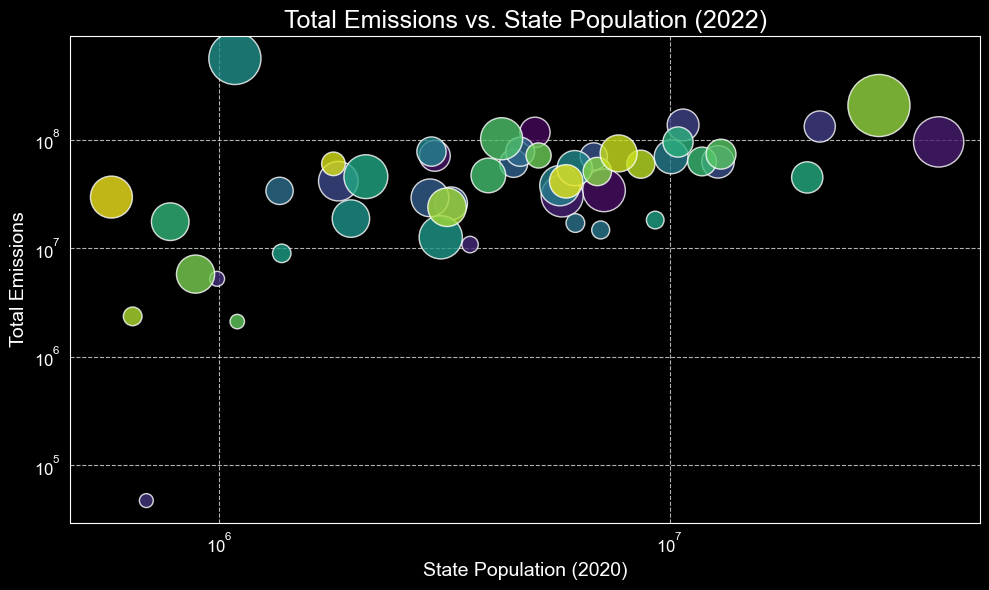

In [86]:

# 4.2 Total Emissions vs. State Population (Scatter plot, latest year)
df_state_pop_emissions_latest = df_latest_year.groupby('state').agg(
        total_emissions=('emissions_quantity', 'sum'),
        pop2020=('pop2020', 'mean'), # Pop is constant per state, so mean is fine
        area_sq_mile = ('area_sq_mile', 'mean') # Area is constant per state, so mean is fine

    ).reset_index()

plt.style.use(style='dark_background')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pop2020', y='total_emissions', hue='state', size='area_sq_mile',
                sizes=(100, 2000), data=df_state_pop_emissions_latest, palette='viridis', alpha=0.8, legend= False)
plt.title(f'Total Emissions vs. State Population ({latest_year})', fontsize=18)
plt.xlabel('State Population (2020)', fontsize=14)
plt.ylabel('Total Emissions', fontsize=14)
plt.xscale('log') # Log scale for population due to wide range
plt.yscale('log') # Log scale for emissions due to wide range
plt.grid(True, linestyle='--', alpha=0.7)
# plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

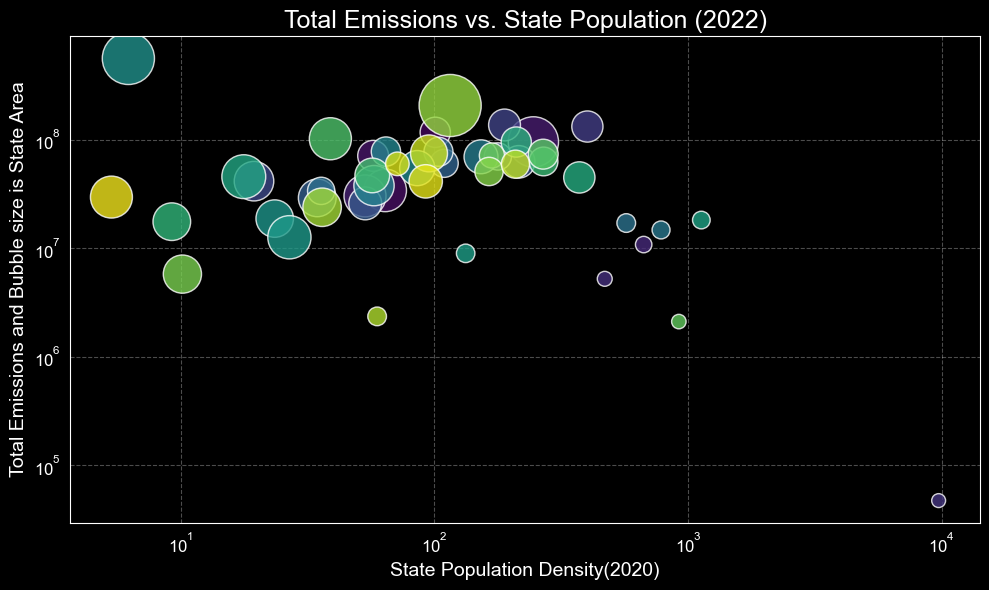

In [87]:

# 4.2 Total Emissions vs. State Population Density (Scatter plot, latest year)
df_state_pop_emissions_latest = df_latest_year.groupby('state').agg(
    total_emissions=('emissions_quantity', 'sum'),
    popDensity=('popDensity_popSqMile', 'mean') ,# Pop is constant per state, so mean is fine
    area_sq_mile = ('area_sq_mile', 'mean') # Area is constant per state, so mean is fine
).reset_index()

plt.style.use(style='dark_background')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='popDensity', y='total_emissions', hue='state', size='area_sq_mile',
                sizes=(100, 2000), data=df_state_pop_emissions_latest, palette='viridis', alpha=0.8, legend= False)
plt.title(f'Total Emissions vs. State Population ({latest_year})', fontsize=18)
plt.xlabel('State Population Density(2020)', fontsize=14)
plt.ylabel('Total Emissions and Bubble size is State Area', fontsize=14)
plt.xscale('log') # Log scale for population due to wide range
plt.yscale('log') # Log scale for emissions due to wide range
plt.grid(True, linestyle='--', alpha=0.3)
# plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


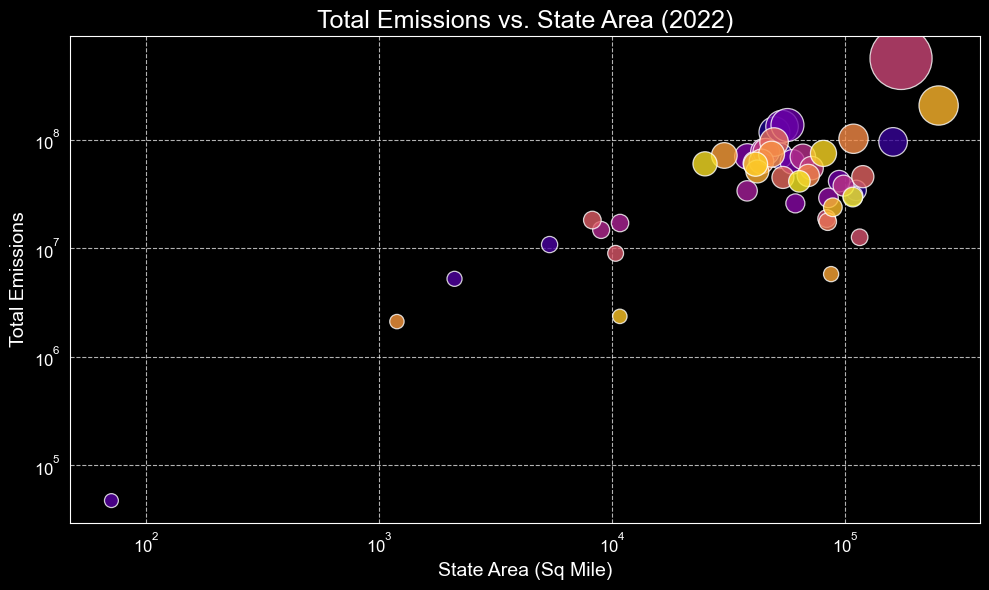

In [88]:

# 4.3 Total Emissions vs. State Area (Scatter plot, latest year)
df_state_area_emissions_latest = df_latest_year.groupby('state').agg(
    total_emissions=('emissions_quantity', 'sum'),
    area_sq_mile=('area_sq_mile', 'mean') # Area is constant per state
).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='area_sq_mile', y='total_emissions', hue='state', size='total_emissions',
                sizes=(100, 2000), data=df_state_area_emissions_latest, palette='plasma', alpha=0.8)
plt.title(f'Total Emissions vs. State Area ({latest_year})', fontsize=18)
plt.xlabel('State Area (Sq Mile)', fontsize=14)
plt.ylabel('Total Emissions', fontsize=14)
plt.xscale('log') # Log scale for area
plt.yscale('log') # Log scale for emissions
plt.grid(True, linestyle='--', alpha=0.7)
# plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend().remove()  # Remove legend to avoid clutter
plt.tight_layout()
plt.show()


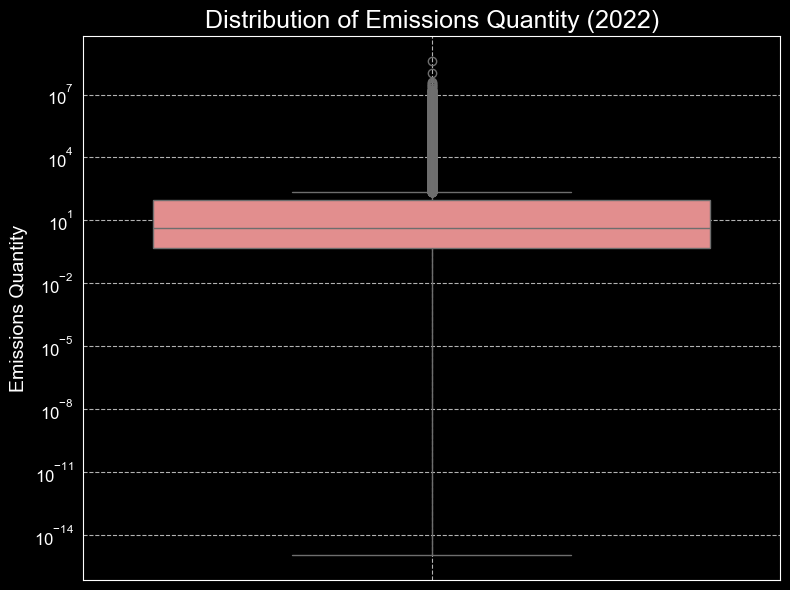

In [89]:

# 5.2 Distribution of Emissions (Overall, for latest year) - Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_latest_year['emissions_quantity'], color='lightcoral')
plt.title(f'Distribution of Emissions Quantity ({latest_year})', fontsize=18)
plt.ylabel('Emissions Quantity', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7
)
plt.yscale('log') # 

plt.tight_layout()
plt.show()

C:\Users\madhur\AppData\Local\Temp\ipykernel_33848\3599440045.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='gas', y='emissions_quantity', data=df, palette='viridis')


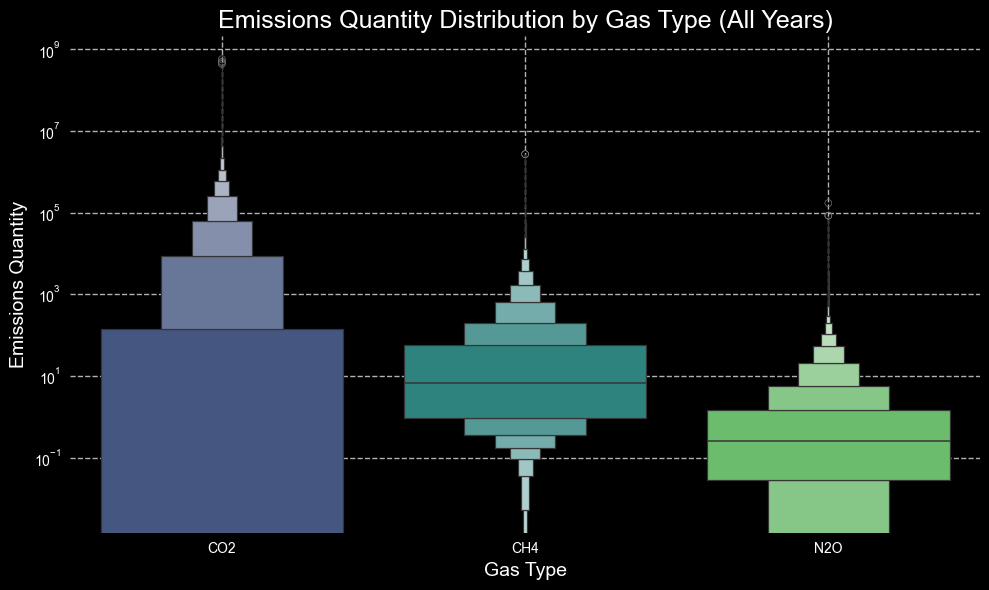

In [90]:
# 6.4 Emissions Quantity Distribution by Gas Type (Violin Plot, all years)
# Use the full df to show N2O/CO2 as zero
plt.style.use('seaborn-v0_8') # Reset to default style for better visibility of grouped bar chart
plt.style.use('dark_background')


plt.figure(figsize=(10, 6))
sns.boxenplot(x='gas', y='emissions_quantity', data=df, palette='viridis')
plt.title('Emissions Quantity Distribution by Gas Type (All Years)', fontsize=18)
plt.xlabel('Gas Type', fontsize=14)
plt.ylabel('Emissions Quantity', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale('log') # Log scale

plt.tight_layout()
plt.show()

In [ ]:
df_latest_year.head(3)

,source_ID,Emission_Sector,EmissionSubsector_Broad,EmissionSubsector_Granular,SourceType_Broad,SourceType_Granular,gas,year,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_factor,capacity_units,activity,activity_units,lat,lon,state,state_code,pop2020,area_sq_mile,popDensity_popSqMile,emissions_per_capacity,emissions_per_activity
75249,75945,Agriculture,Enteric Fermentation by Cattle,Enteric Fermentation by Cattle,Animal-based Products,Beef,CH4,2022,103.9,0.053,T of CH4 per animal head,1.0,1960.0,hectares,1960.0,animals,36.064060,-119.36576,California,CA,39538223,160878.883916,245.763907,103.9,0.053010
75268,75964,Agriculture,Enteric Fermentation by Cattle,Enteric Fermentation by Cattle,Animal-based Products,Beef,CH4,2022,296.8,0.053,T of CH4 per animal head,1.0,5600.0,hectares,5600.0,animals,36.167480,-119.33781,California,CA,39538223,160878.883916,245.763907,296.8,0.053000
75313,76009,Agriculture,Enteric Fermentation by Cattle,Enteric Fermentation by Cattle,Animal-based Products,Beef,CH4,2022,29.7,0.053,T of CH4 per animal head,1.0,560.0,hectares,560.0,animals,36.238701,-119.29613,California,CA,39538223,160878.883916,245.763907,29.7,0.053036


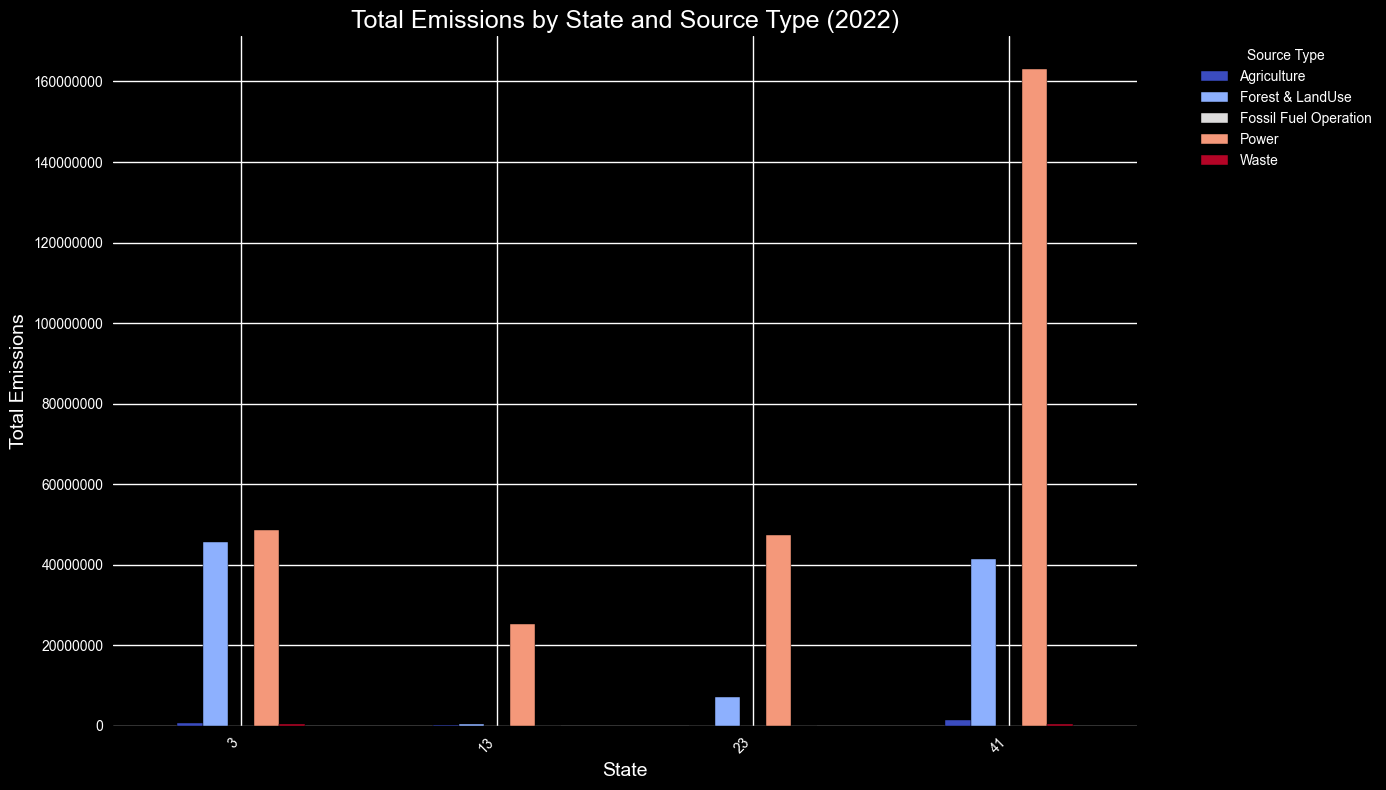

In [91]:
# 6.5 Total Emissions Quantity by State and Emission_Sector - but do stacked bar plot for top 5 state - Latest Year

plt.style.use('seaborn-v0_8') 
plt.style.use('dark_background')
total_emissions_state_source_latest = df_latest_year.groupby(['state', 'Emission_Sector'])['emissions_quantity'].sum().unstack(fill_value=0).reset_index()
total_emissions_state_source_latest_2_plot = total_emissions_state_source_latest[total_emissions_state_source_latest['state'].isin(top_states_for_box_evolution)].copy()
    
total_emissions_state_source_latest_2_plot.plot(kind='bar', figsize=(14, 8), colormap='coolwarm', edgecolor='black')
plt.title(f'Total Emissions by State and Source Type ({latest_year})', fontsize=18)
plt.xlabel('State', fontsize=14)
plt.ylabel('Total Emissions', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Source Type', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


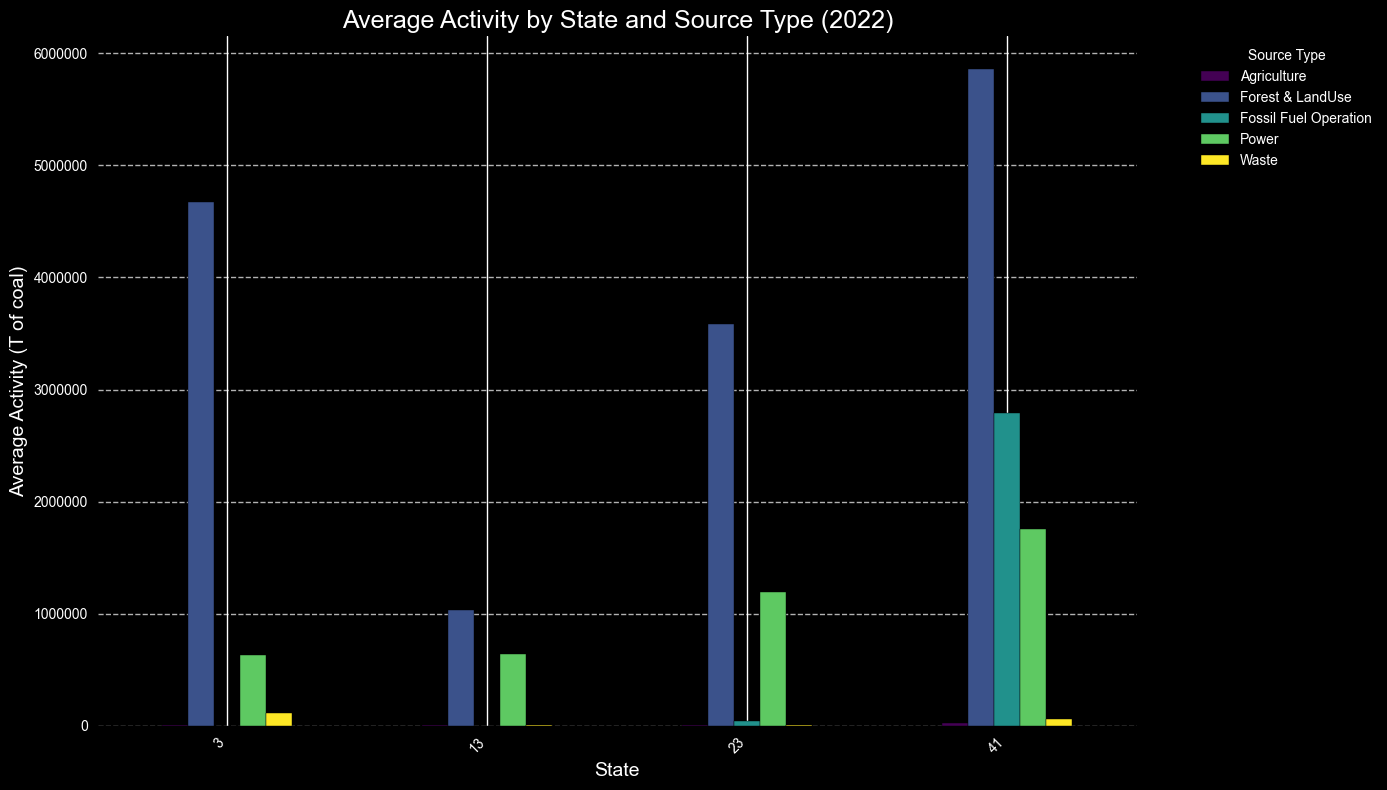

In [92]:
# 6.6 Average Activity by State and Emission_Sector- but do stacked bar plot for top 5 state - Latest Year
### plot style light mode
plt.style.use( 'seaborn-v0_8' )
plt.style.use('dark_background')

avg_activity_state_source_latest = df_latest_year.groupby(['state', 'Emission_Sector'])['activity'].mean().unstack(fill_value=0).reset_index()
latest_2_plot = avg_activity_state_source_latest[avg_activity_state_source_latest['state'].isin(top_states_for_box_evolution)].copy()

latest_2_plot.plot(kind='bar', figsize=(14, 8), colormap='viridis', edgecolor='black')
plt.title(f'Average Activity by State and Source Type ({latest_year})', fontsize=18)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Activity (T of coal)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Source Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


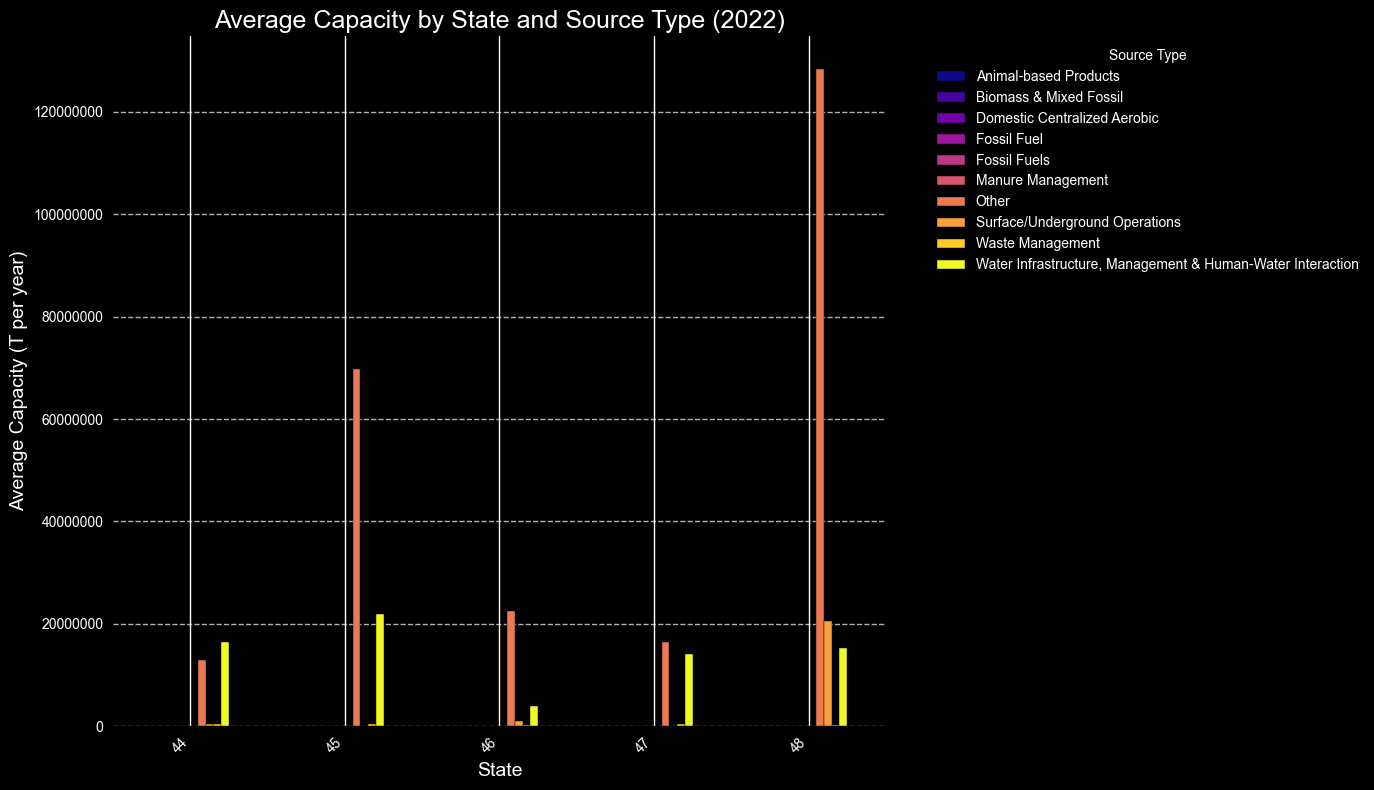

In [93]:
# 6.7 Average Capacity by State and Source Type (Grouped Bar Chart) - Latest Year
plt.style.use( 'seaborn-v0_8' )
plt.style.use('dark_background')

df_latest_year.groupby(['state', 'SourceType_Broad'])['capacity'].mean().reset_index()

highestAverage_capacity_state_ls = df_latest_year.groupby(['state'])['capacity'].mean().reset_index().sort_values( by= 'state', ascending=False ).head(5)['state'].tolist()


avg_capacity_state_source_latest = df_latest_year.groupby(['state', 'SourceType_Broad'])['capacity'].mean().unstack(fill_value=0).reset_index()
df2plot = avg_capacity_state_source_latest[ avg_capacity_state_source_latest['state'].isin( highestAverage_capacity_state_ls ) ]  

# df2plot.plot(kind='bar', figsize=(14, 8), colormap='plasma', edgecolor='black')
df2plot.plot(kind='bar', figsize=(14, 8), colormap='plasma', edgecolor='black')
plt.title(f'Average Capacity by State and Source Type ({latest_year})', fontsize=18)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Capacity (T per year)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Source Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

C:\Users\madhur\AppData\Local\Temp\ipykernel_33848\2079638599.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Regression Line', loc='upper left')


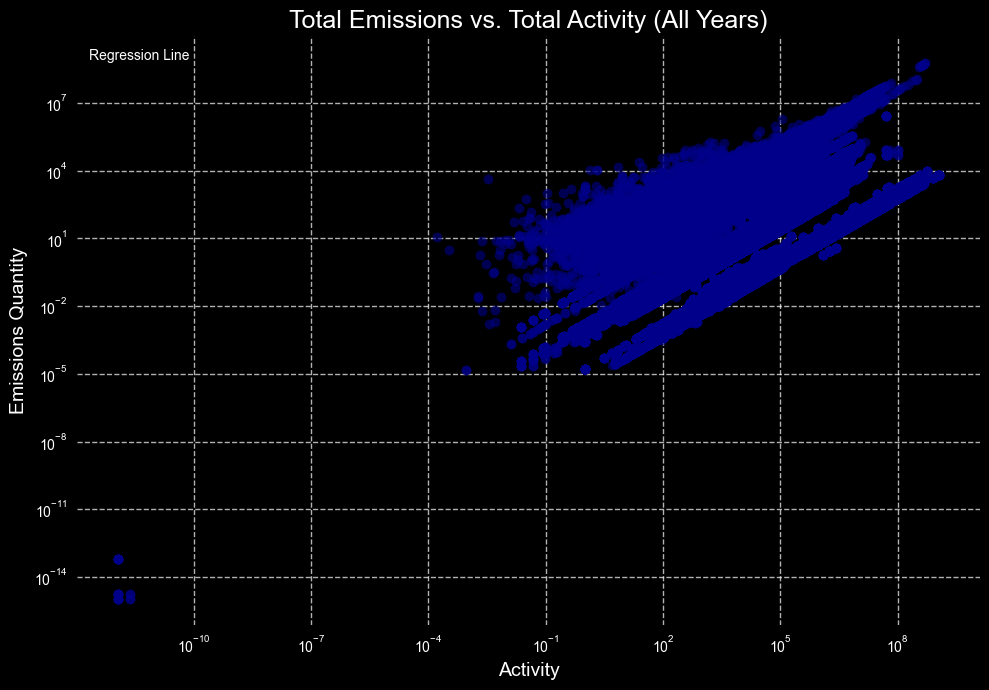

In [94]:
# 6.8 Total Emissions vs. Total Activity (Scatter Plot with Regression) - All Years ...
# transofrm emissions_quantity & Activity to log and then fir regression line
#  
plt.figure(figsize=(10, 7))
sns.regplot(x='activity', y='emissions_quantity', data=df_nonzero_emissions,
            scatter_kws={'alpha':0.6, 'color':'darkblue'}, line_kws={'color':'red'}, fit_reg= False ) 
plt.title('Total Emissions vs. Total Activity (All Years)', fontsize=18)
plt.xlabel('Activity', fontsize=14)
plt.ylabel('Emissions Quantity', fontsize=14)
plt.xscale('log');  plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Regression Line', loc='upper left')
plt.tight_layout()
plt.show()

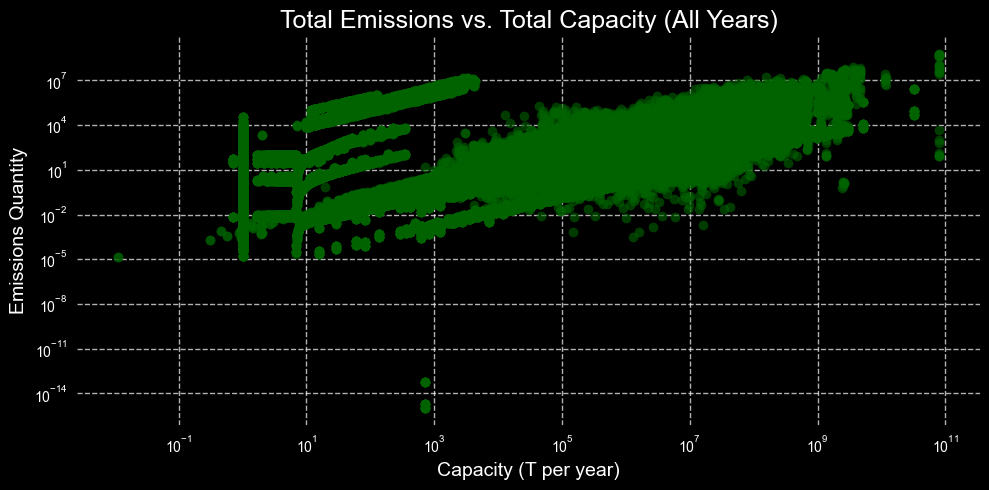

In [ ]:
# 6.9 Total Emissions vs. Total Capacity (Scatter Plot with Regression) - All Years
plt.figure(figsize=(10, 5))
sns.regplot(x='capacity', y='emissions_quantity', data=df_nonzero_emissions,
            scatter_kws={'alpha':0.6, 'color':'darkgreen'}, line_kws={'color':'red'}, fit_reg= False )
plt.title('Total Emissions vs. Total Capacity (All Years)', fontsize=18)
plt.xlabel('Capacity (T per year)', fontsize=14)
plt.ylabel('Emissions Quantity', fontsize=14)
plt.xscale('log'); plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# 6.10 Geospatial Heatmap of Emission Density (Latest Year)
# Using kernel density estimate for a heatmap
plt.figure(figsize=(17, 9))
sns.kdeplot(x='lon', y='lat', data=df_latest_year_nonzero_emissions,
            cmap='hot_r', fill=True, cbar=True, levels=10)
sns.scatterplot(x='lon', y='lat', data=df_latest_year_nonzero_emissions, color='blue', alpha=0.3, s=10) # Overlay points for context
plt.title(f'Geospatial Density of Emission Sources ({latest_year})', fontsize=18)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\madhur\AppData\Local\Temp\ipykernel_33848\2823854183.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_emissions_by_state.index, y=total_emissions_by_state.values, palette='Blues_d')


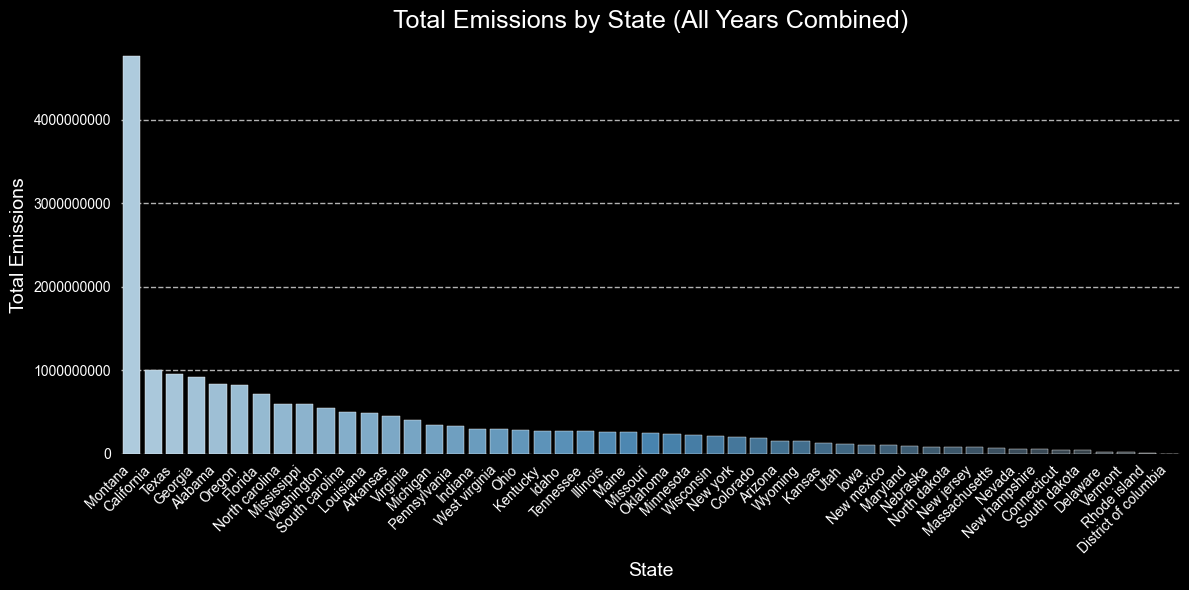

In [97]:
# 6.11 Total Emissions by State (Bar Chart, all years combined)
## dark mode
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
total_emissions_by_state = df_nonzero_emissions.groupby('state')['emissions_quantity'].sum().sort_values(ascending=False)
sns.barplot(x=total_emissions_by_state.index, y=total_emissions_by_state.values, palette='Blues_d')
plt.title('Total Emissions by State (All Years Combined)', fontsize=18)
plt.xlabel('State', fontsize=14)
plt.ylabel('Total Emissions', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


C:\Users\madhur\AppData\Local\Temp\ipykernel_33848\3917217559.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_emissions_by_state.index, y=avg_emissions_by_state.values, palette='Greens_d')


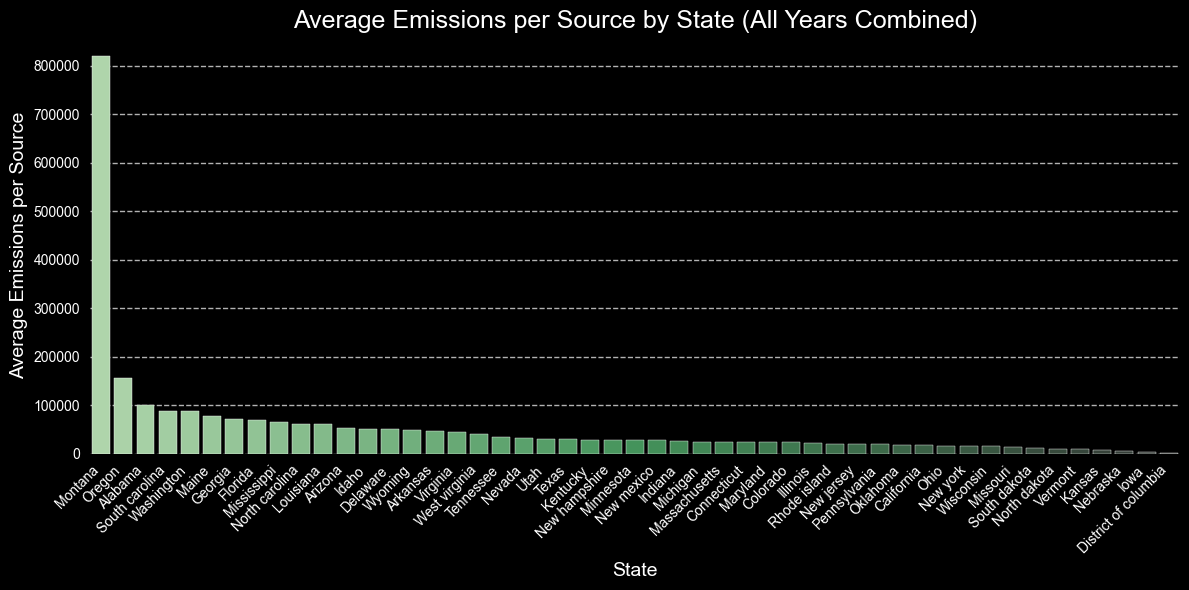

In [99]:
# 6.12 Average Emissions per Source by State (All Years Combined)
plt.figure(figsize=(12, 6))
avg_emissions_by_state = df_nonzero_emissions.groupby('state')['emissions_quantity'].mean().sort_values(ascending=False)
sns.barplot(x=avg_emissions_by_state.index, y=avg_emissions_by_state.values, palette='Greens_d')
plt.title('Average Emissions per Source by State (All Years Combined)', fontsize=18)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Emissions per Source', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

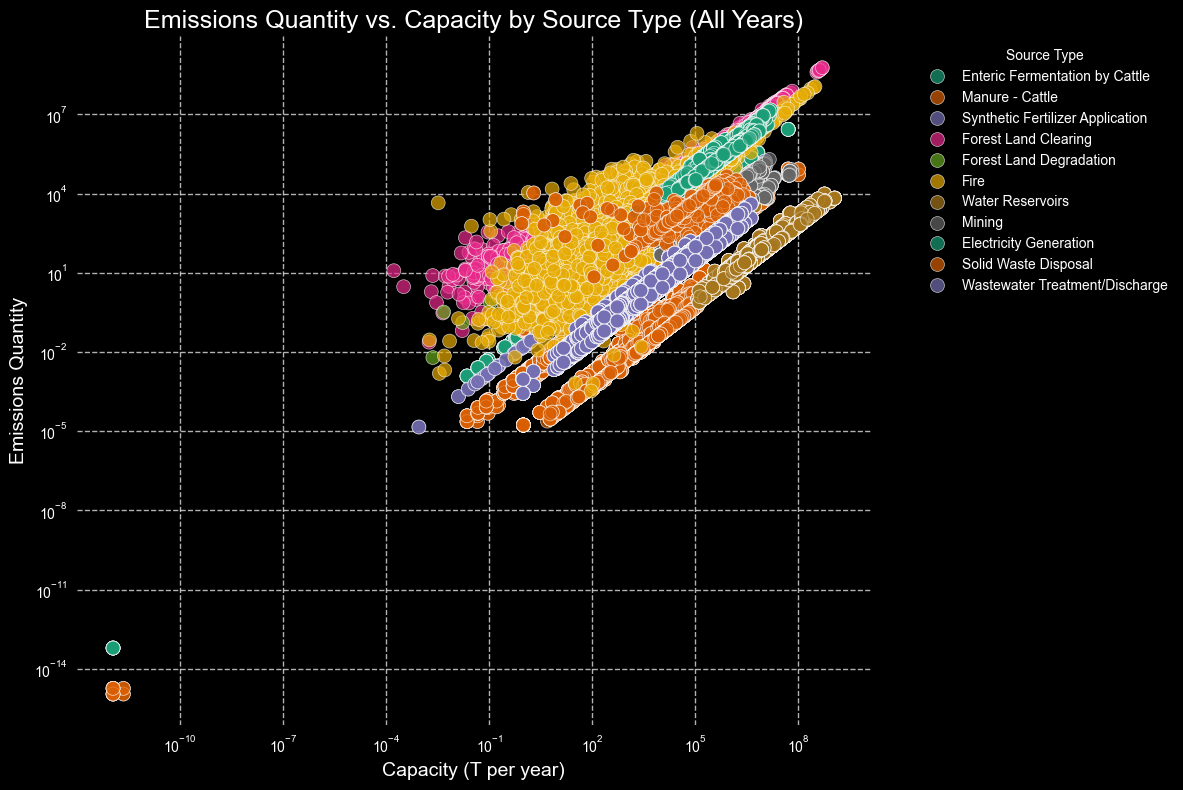

In [100]:
# 6.15 Emissions Quantity vs. Capacity (Scatter Plot, all years, colored by Source Type)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='activity', y='emissions_quantity', hue='EmissionSubsector_Broad', data=df_nonzero_emissions,
                s=100, alpha=0.7, palette='Dark2', edgecolor='w', linewidth=0.5)
plt.title('Emissions Quantity vs. Capacity by Source Type (All Years)', fontsize=18)
plt.xlabel('Capacity (T per year)', fontsize=14)
plt.ylabel('Emissions Quantity', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Source Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<Figure size 1500x900 with 0 Axes>

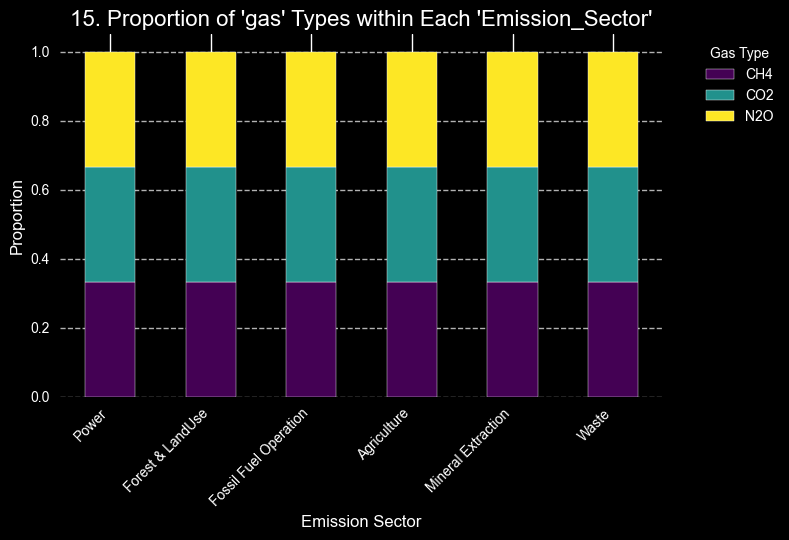

In [101]:
# 15. Stacked Bar Chart: 'gas' distribution within each 'Emission_Sector'
sector_gas_counts = df.groupby(['Emission_Sector', 'gas']).size().unstack(fill_value=0)
sector_gas_proportions = sector_gas_counts.apply(lambda x: x / x.sum(), axis=1)
sector_order = df.groupby('Emission_Sector')['emissions_quantity'].sum().sort_values(ascending=False).index

plt.figure(figsize=(15, 9))
sector_gas_proportions.loc[sector_order].plot(kind='bar', stacked=True, colormap='viridis')
plt.title('15. Proportion of \'gas\' Types within Each \'Emission_Sector\'', fontsize=16)
plt.xlabel('Emission Sector', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gas Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\madhur\AppData\Local\Temp\ipykernel_33848\999859278.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gas Type', bbox_to_anchor=(1.05, 1), loc='upper left')


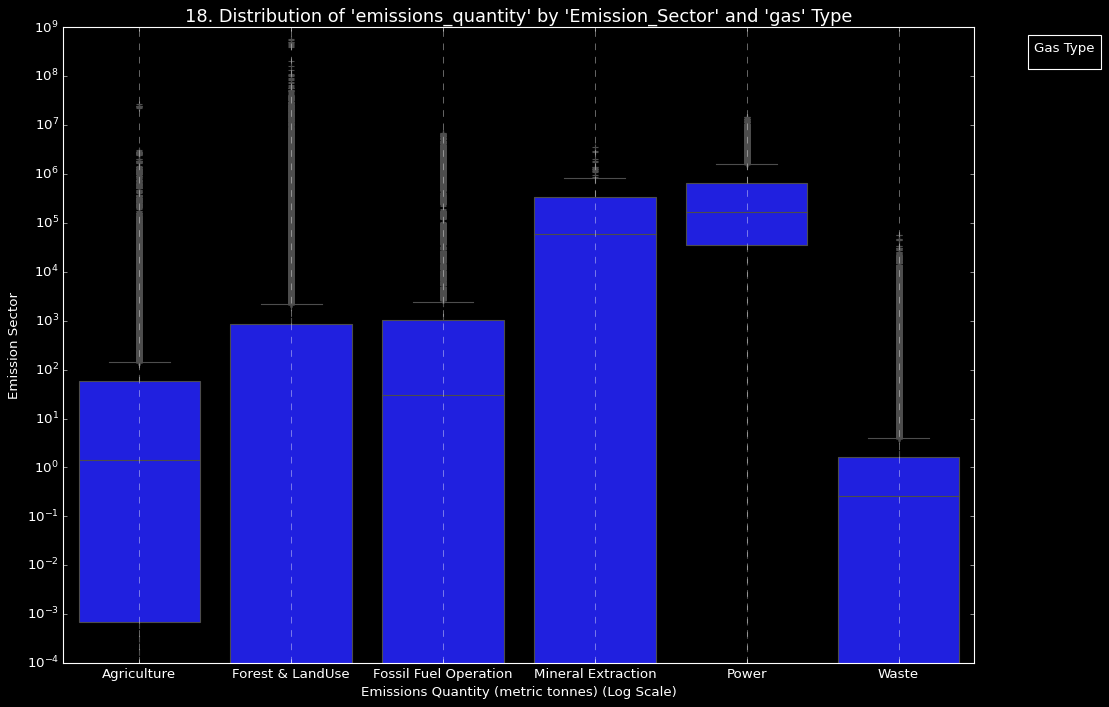

In [102]:
# 18. Violin Plot with Split Distributions: 'emissions_quantity' by 'Emission_Sector' 
plt.style.use( style= 'classic' )
plt.style.use( style= 'dark_background' )


plt.figure(figsize=(14, 9))
# sns.violinplot(x='emissions_quantity', y='Emission_Sector', hue='gas', data=df_filtered_for_split_violin, split=True, inner='quartile', palette='coolwarm')
sns.boxplot( y='emissions_quantity', x='Emission_Sector',  data= df )
plt.title('18. Distribution of \'emissions_quantity\' by \'Emission_Sector\' and \'gas\' Type', fontsize=16)
plt.xlabel('Emissions Quantity (metric tonnes) (Log Scale)', fontsize=12)
plt.ylabel('Emission Sector', fontsize=12)
plt.yscale('log')
plt.legend(title='Gas Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

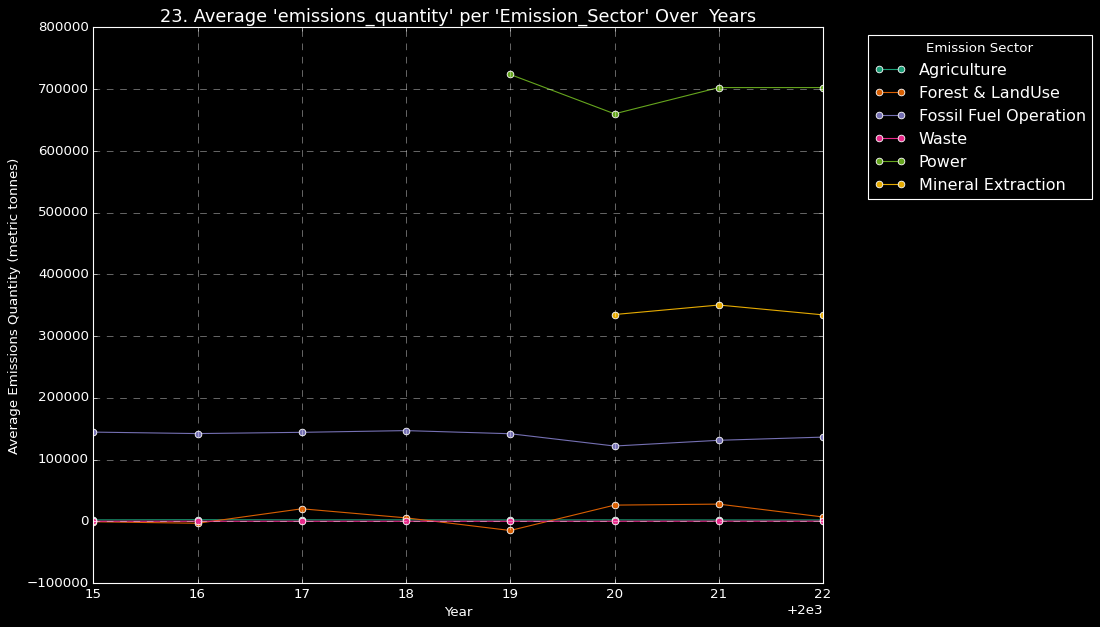

In [103]:
# 23. Line Plot: Average 'emissions_quantity' per 'Emission_Sector' over 'year'
top_sectors_time = df.groupby('Emission_Sector')['emissions_quantity'].sum().nlargest(6).index
df_filtered_sectors_time = df[df['Emission_Sector'].isin(top_sectors_time)]

avg_emissions_sector_year = df_filtered_sectors_time.groupby(['year', 'Emission_Sector'])['emissions_quantity'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='year', y='emissions_quantity', hue='Emission_Sector', data=avg_emissions_sector_year, marker='o', palette='Dark2')
plt.title('23. Average \'emissions_quantity\' per \'Emission_Sector\' Over  Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Emissions Quantity (metric tonnes)', fontsize=12)
plt.xticks(avg_emissions_sector_year['year'].unique())
plt.legend(title='Emission Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


c:\Users\madhur\anaconda3\envs\ds_311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


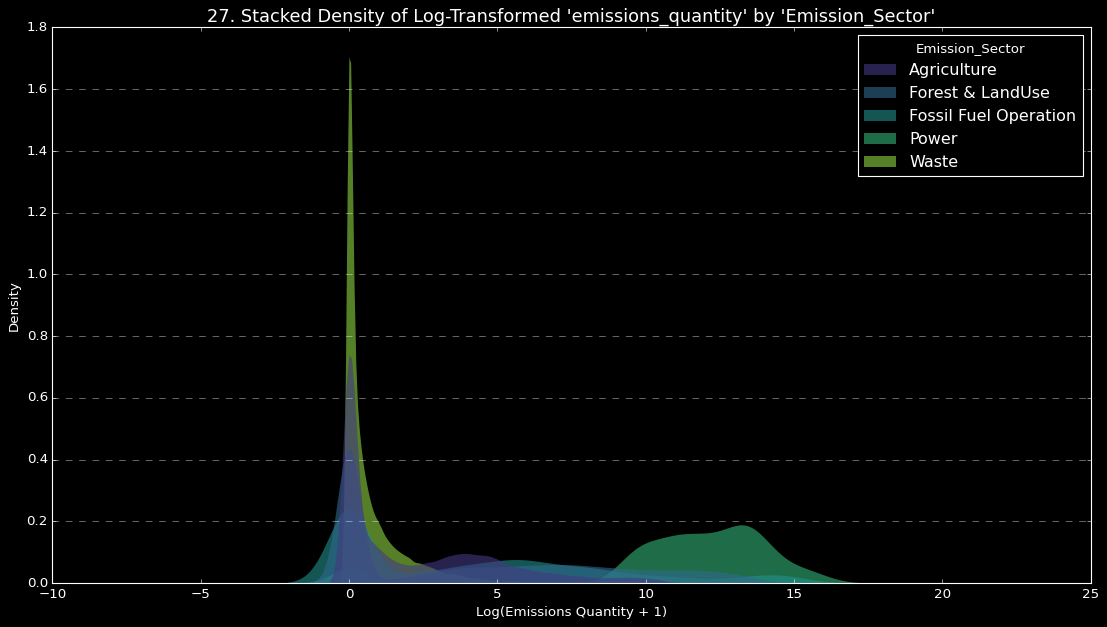

In [105]:
# 27. Stacked Density Plot of 'emissions_quantity' by 'Emission_Sector'
# Filter for top N sectors for readability
top_n_sectors_density = df['Emission_Sector'].value_counts().nlargest(5).index
df_filtered_density = df[df['Emission_Sector'].isin(top_n_sectors_density)].copy()

# Apply log transformation for density plot if data is highly skewed
df_filtered_density['emissions_quantity_log'] = np.log1p(df_filtered_density['emissions_quantity'])

plt.figure(figsize=(14, 8))
sns.kdeplot(data=df_filtered_density, x='emissions_quantity_log', hue='Emission_Sector',
            fill=True, common_norm=False, palette='viridis', alpha=0.6, linewidth=0)
plt.title('27. Stacked Density of Log-Transformed \'emissions_quantity\' by \'Emission_Sector\'', fontsize=16)
plt.xlabel('Log(Emissions Quantity + 1)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

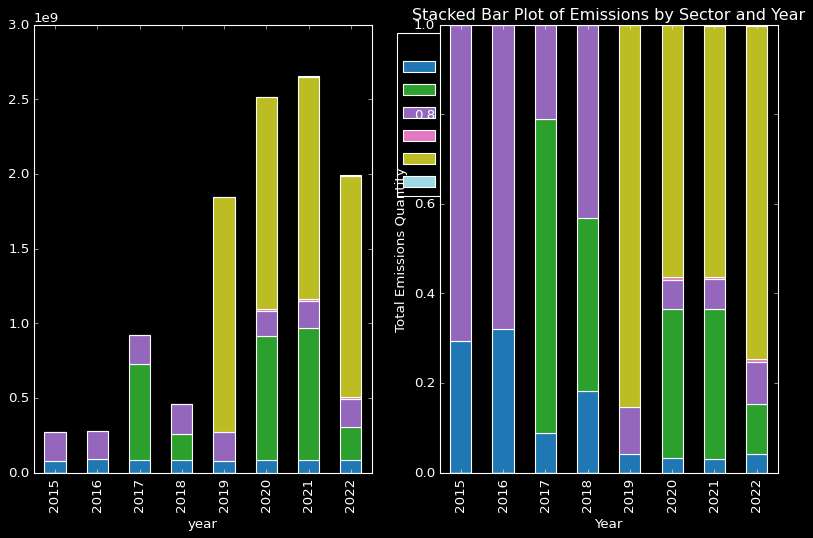

In [108]:
source_type_subsector_counts = df.groupby( ['year', 'Emission_Sector'] )['emissions_quantity'].sum().reset_index()

source_type_subsector_counts_pos = copy.deepcopy(source_type_subsector_counts)

source_type_subsector_counts_pos['emissions_quantity'] = source_type_subsector_counts['emissions_quantity'].clip( lower = 0 )


pivot_df = source_type_subsector_counts_pos.pivot( index='year', columns='Emission_Sector', values='emissions_quantity' ).fillna(0)
# pivot_df = source_type_subsector_counts_pos.pivot(index='year', columns='Emission_Sector', values='emissions_quantity').fillna(0)
# Normalize each row to sum to 1 (100%)
fg, ax = plt.subplots( figsize=(25, 6), nrows=1, ncols=2 )
pivot_df_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0)

pivot_df.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='tab20', ax=ax[0])
pivot_df_pct.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='tab20', ax=ax[1])

# pivot_df_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0)
# pivot_df_pct.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='tab20')
plt.title('Stacked Bar Plot of Emissions by Sector and Year')
plt.xlabel('Year')
plt.ylabel('Total Emissions Quantity')
ax[0].legend(title='Emission Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend_.remove()  # Remove legend for percentage plot to avoid clutter

# plt.tight_layout(); 
# plt.show()